Setup Packages and Functions
===

In [10]:
# import pystan
import stanity
n_jobs = 4
import pandas as pd
import seaborn as sns
sns.set_color_codes()
%pylab inline
from scipy.stats import norm, truncnorm, multivariate_normal, lognorm, gaussian_kde

Populating the interactive namespace from numpy and matplotlib


/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['norm', 'multivariate_normal']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [11]:
from pystan.misc import _summary, _array_to_table
def _print_stanfit(fit, pars=None, probs=(0.025, 0.25, 0.5, 0.75, 0.975), digits_summary=2):
        if fit.mode == 1:
            return "Stan model '{}' is of mode 'test_grad';\n"\
                   "sampling is not conducted.".format(fit.model_name)
        elif fit.mode == 2:
            return "Stan model '{}' does not contain samples.".format(fit.model_name)
        if pars is None:
            pars = fit.sim['pars_oi']
            fnames = fit.sim['fnames_oi']

        n_kept = [s - w for s, w in zip(fit.sim['n_save'], fit.sim['warmup2'])]
        header = ""#Inference for Stan model: {}.\n".format(fit.model_name)
        header += "{} chains, each with iter={}; warmup={}; thin={}; \n"
        header = header.format(fit.sim['chains'], fit.sim['iter'], fit.sim['warmup'],
                               fit.sim['thin'], sum(n_kept))
        header += "post-warmup draws per chain={}, total post-warmup draws={}.\n\n"
        header = header.format(n_kept[0], sum(n_kept))
        footer = "\n\nSamples were drawn using {} at {}.\n"\
#             "For each parameter, n_eff is a crude measure of effective sample size,\n"\
#             "and Rhat is the potential scale reduction factor on split chains (at \n"\
#             "convergence, Rhat=1)."
        sampler = fit.sim['samples'][0]['args']['sampler_t']
        date = fit.date.strftime('%c')  # %c is locale's representation
        footer = footer.format(sampler, date)
        s = _summary(fit, pars, probs)
        body = _array_to_table(s['summary'], s['summary_rownames'],
                               s['summary_colnames'], digits_summary)
        return header + body + footer
    
def plot_time_series_inference(model_fit, var='Y_sim', x=None,
                               ax=None, ind=0, **kwargs):
    from scipy.stats import scoreatpercentile
    ci_thresholds = [2.5, 25, 75, 97.5]
    if len(model_fit[var].shape)<3:
        data = model_fit[var]
    else:
        data = model_fit[var][:,:,ind]
    CIs = scoreatpercentile(data, ci_thresholds, axis=0)
    CIs = pd.DataFrame(data=CIs.T, columns=ci_thresholds)
    if ax is None:
        ax=gca()
    if x is None:
        x = arange(data.shape[1])
    ax.fill_between(x, CIs[2.5], CIs[97.5],alpha=.5, **kwargs)
    ax.fill_between(x, CIs[25], CIs[75], **kwargs)
    
from scipy.stats import percentileofscore
def portion_of_data_within_CI(model_fit, parameter, data, lower=2.5, upper=97.5):
    if data.ndim<2:
        a = array((list(map(percentileofscore, model_fit[parameter].T, data))))
        return mean((lower<a)*(a<upper))
    else:
        values = empty(data.shape[1])
        for i in range(data.shape[1]):
            a = array((list(map(percentileofscore, model_fit[parameter][:,i], data.iloc[:,i]))))
            values[i]=nanmean((lower<a)*(a<upper))
        return values
    
def portion_of_forecast_within_CI(model_fit, forecast, data, 
                                  forecast_start_ind, forecast_stop_ind,
                                  lower=2.5, upper=97.5):
    u = percentile(model_fit[forecast],upper,axis=0)
    l = percentile(model_fit[forecast],lower,axis=0)
    return nanmean((l.T[forecast_start_ind:forecast_stop_ind]<data[forecast_start_ind:forecast_stop_ind])*
                   (data[forecast_start_ind:forecast_stop_ind]<u.T[forecast_start_ind:forecast_stop_ind]),
                  axis=0)

def calculate_Omega_from_L_Omega(model_fit):
    f = lambda x,y: matrix(x)*matrix(y)
    return list(map(f, model_fit['L_Omega'], transpose(model_fit['L_Omega'],[0,2,1])))

def calculate_covariance_from_L_Omega_and_tau(model_fit):
    Omegas = calculate_Omega_from_L_Omega(model_fit)
    f = lambda tau, Omega: diag(tau)*Omega*diag(tau)
    return list(map(f, model_fit['tau'], Omegas))

Load Empirical Data and Look at It
===

In [12]:
data_directory = '../data/'

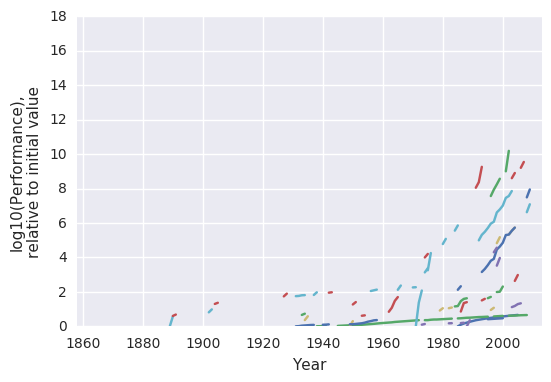

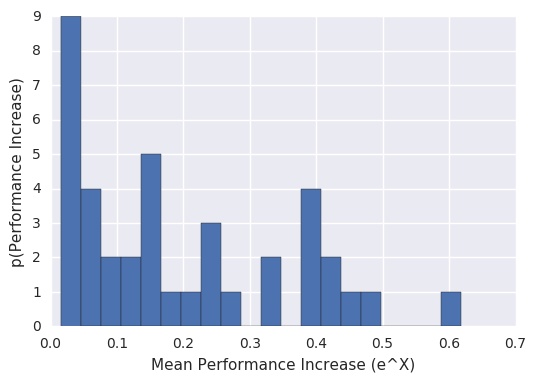

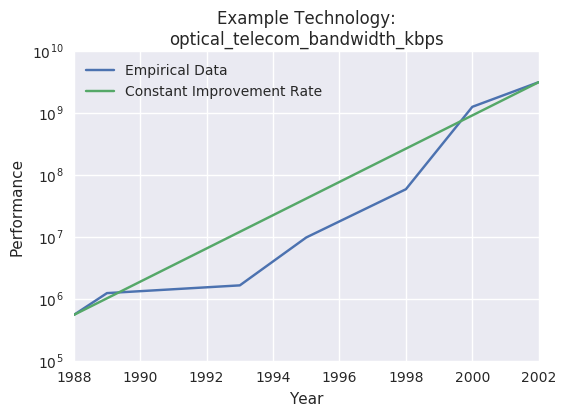

In [13]:
empirical_data = pd.read_csv(data_directory+'time_series.csv',index_col=0)
empirical_data = empirical_data.reindex(arange(empirical_data.index[0],empirical_data.index[-1]+1))
metadata = pd.read_csv(data_directory+'time_series_metadata.csv')

target_tech_names = metadata.ix[metadata['Type']=='Performance', 'Name']

figure()
q = empirical_data[target_tech_names]
r = q
r = r/r.apply(lambda x: x.ix[pd.Series.first_valid_index(x)])
r = log10(r)
r.plot(legend=False,kind='line')
xlabel("Year")
ylabel("log10(Performance),\nrelative to initial value")

figure()
z = log(q).apply(lambda x: (x.ix[x.last_valid_index()]-x.ix[x.first_valid_index()])/(x.last_valid_index()-x.first_valid_index()))
z.hist(bins=20)
xlabel("Mean Performance Increase (e^X)")
ylabel("p(Performance Increase)")

figure()
title("Example Technology:\n%s"%z.argmax())
n = (q)[z.argmax()].dropna()
n.plot(label='Empirical Data')
y = [n.iloc[0]]
for i in arange(n.index[0], n.index[-1]):
    y.append(y[-1]*exp(z.max()))
plot(arange(n.index[0], n.index[-1]+1), y, label='Constant Improvement Rate')
yscale('log')
legend(loc='upper left')
xlabel("Year")
ylabel("Performance")

Define Time Series Models and Ensure They Correctly Fit to Simulated Data
===

First, create some building blocks that we'll use in virtually all of our models
----

In [14]:
functions_string = """    
int first_observation_ind(vector my_array){
    int t;
    t = 1;
    while(my_array[t] < -900){
      t = t+1;
    }
    return t;
}

int last_observation_ind(vector my_array, int length){
    int last_observation;
    last_observation = 0; 
    for(t in 1:length){
      if(my_array[t] > -900){
          last_observation = t;
      }
    }
    return last_observation;
}


int count_n_observations(vector my_array) {
    int count;
    count = 0;
    for (t in 1:num_elements(my_array)) {
        if(my_array[t] > -900){
            count = count + 1;
        }
    }
    return count;
}

real lower_truncated_normal_lpdf(real x, real mu, real sigma, real A) {
    return(normal_lpdf(x | mu, sigma) - normal_lccdf(A | mu, sigma));
}

real lower_truncated_normal_lpdf_vector(vector x, real mu, real sigma, real A) {
    return(normal_lpdf(x | mu, sigma) - normal_lccdf(A | mu, sigma));
}
"""

data_string = """
int N_time_periods; // number of time periods
vector[N_time_periods] Y; // value each time period 
int N_time_periods_for_inference;
%(priors)s
"""

transformed_data_string="""
int first_observation;
int last_observation;
int N_observed_time_periods_for_inference;
int r_offset;
int n_observations;

first_observation = first_observation_ind(Y[1:N_time_periods_for_inference]);
last_observation = last_observation_ind(Y[1:N_time_periods_for_inference], 
                  N_time_periods_for_inference);

N_observed_time_periods_for_inference = last_observation-first_observation + 1;
r_offset = first_observation-1;

n_observations = count_n_observations(Y);
"""

parameters_string="""
vector<lower = 0,upper = 1>[N_observed_time_periods_for_inference-1] r_raw; // updates
%(parameters)s
"""

transformed_parameters_string="""
// Identify where the first and last non-missing data points are in Y
vector<lower = 0>[N_observed_time_periods_for_inference-1] r; // updates

{
// Dictate that the total change between each pair of observations is equal to the observed change between them
// This is relevant for time periods with missing data
int most_recent_observation;
most_recent_observation = first_observation;
for(t in first_observation+1:last_observation) {
  if(Y[t] > -900) {
    r[(most_recent_observation-r_offset):((t-1)-r_offset)] = 
    r_raw[(most_recent_observation-r_offset):((t-1)-r_offset)] /
    sum(r_raw[(most_recent_observation-r_offset):((t-1)-r_offset)]) * 
    (Y[t]-Y[most_recent_observation]);
    most_recent_observation = t;
    }
}
}
"""

generated_quantities_string = """
vector[N_time_periods] Y_sim;
vector[N_time_periods] log_likelihood;
real mean_change;
real variance_change;

mean_change = mean(r);
variance_change = variance(r);

//Fill out data in the missing periods
for(t in first_observation:last_observation) {
  if(Y[t] > -900){
      Y_sim[t] = Y[t];
  } else{
      Y_sim[t] = Y_sim[t-1] + r[(t-1)-r_offset];
  } 
}
{
real increase_size;
//Fill out future data points
for(t in last_observation+1:N_time_periods){
    // Stan cannot yet generate numbers from a truncated distribution directly, so we have to do this silly thing. 
    // As of version 2.12.0, the devs are still talking about it: https://github.com/stan-dev/math/issues/214
    increase_size = -1.0;  
    while (increase_size<0){
        increase_size = %(increase_size)s;
    }
    Y_sim[t] = increase_size + Y_sim[t-1];
}
}

//Fill out past data points
{
int t;
real increase_size;
t = first_observation;
while(t>1){
    increase_size = -1.0;  
    while (increase_size<0){
        increase_size = %(increase_size)s;
    }
    Y_sim[t-1] = Y_sim[t] - increase_size;
    t = t-1;
}
}

for(t in 2:N_time_periods){
    if(Y[t] > -900){
            %(log_likelihood)s;
    }
}
"""

basic_model_string = """
functions{
%(functions_string)s
}

data {
%(data_string)s
}

transformed data {
%(transformed_data_string)s
}
  
parameters {
%(parameters_string)s
}

transformed parameters {
%(transformed_parameters_string)s
}

model {
%(model_string)s
}

generated quantities {
%(generated_quantities_string)s
}
"""%{
'functions_string': functions_string,
'data_string': data_string,
'transformed_data_string': transformed_data_string,
'parameters_string': parameters_string,
'transformed_parameters_string': transformed_parameters_string,
'model_string': '%(model)s',
'generated_quantities_string': generated_quantities_string}

Next, define our models, using those building blocks
---

In [15]:
model_code = {}

model_code['improvement~N(mu,sigma)'] = basic_model_string%{
    'model': """
            mu ~ normal(mu_prior_location, mu_prior_scale);
            sigma ~ cauchy(sigma_prior_location, sigma_prior_scale);

            target += lower_truncated_normal_lpdf_vector(r, mu, sigma, 0);
            """,
    'parameters': """
                    real<lower = 0> mu;
                    real<lower = 0> sigma;
                    """,
    'increase_size': 'normal_rng(mu,sigma)',
    'log_likelihood': 'log_likelihood[t] = lower_truncated_normal_lpdf(Y[t]-Y_sim[t-1]| mu, sigma, 0)',
    'priors': """
            real mu_prior_location;
            real mu_prior_scale;  
            real sigma_prior_location;
            real sigma_prior_scale;"""}

model_code['improvement~bernoulli(theta)N(mu,sigma)'] = basic_model_string%{
    'model': """
            mu ~ normal(mu_prior_location, mu_prior_scale);
            sigma ~ cauchy(sigma_prior_location, sigma_prior_scale);
            theta ~ normal(theta_prior_location, theta_prior_scale);
            
            for(t in 1:N_observed_time_periods_for_inference-1){
                target += log_mix(theta, lower_truncated_normal_lpdf(r[t] | mu, sigma, 0), 
                              lower_truncated_normal_lpdf(r[t] | 0, 0.01, 0));
            }
            """,
    'parameters': """
                real<lower = 0> mu;
                real<lower = 0> sigma;
                real<lower = 0, upper = 1> theta;
                """,
    'increase_size': 'bernoulli_rng(theta) * normal_rng(mu,sigma)',
    'log_likelihood': """
                if((Y[t]-Y_sim[t-1])==0) {
                log_likelihood[t] = log(1-theta);
                } else {
                    log_likelihood[t] = log(theta) + lower_truncated_normal_lpdf(Y[t]-Y_sim[t-1]| mu, sigma, 0);
                }
                """,
    'priors': """
            real mu_prior_location;
            real mu_prior_scale;

            real sigma_prior_location;
            real sigma_prior_scale;

            real theta_prior_location;
            real theta_prior_scale;"""}

Test the models on simulated data
---

Reusing model.
Ran in 6.147 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu      4.74  1.7e-3   0.11   4.53   4.67   4.74   4.81   4.95   4000    1.0
sigma   1.09  1.5e-3   0.09   0.93   1.03   1.08   1.15   1.29   4000    1.0

Samples were drawn using NUTS at Wed Dec  7 03:24:16 2016.

mu: 5.00, inferred mu: 4.74
sigma: 1.00, inferred sigma: 1.09


(0, 160.0)

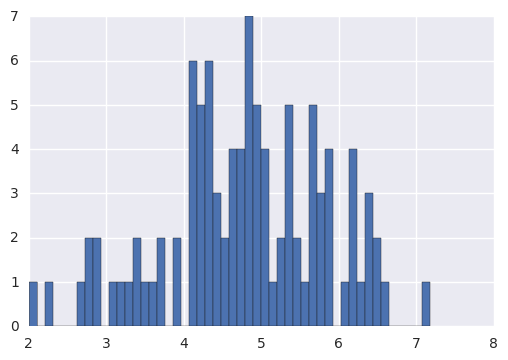

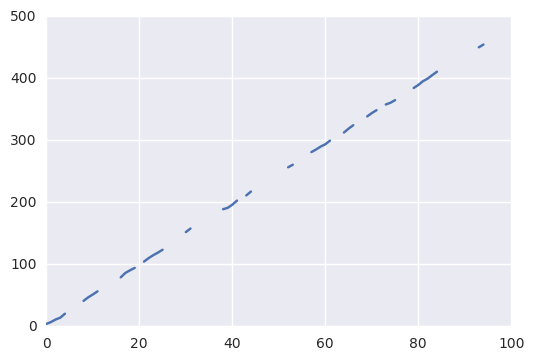

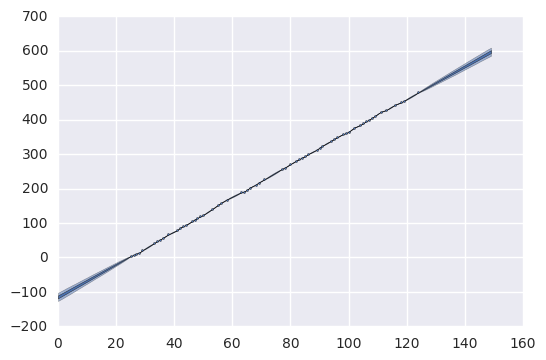

In [16]:
### Random walk, missing data, positive steps
p_missing = 0.3
mu = 5
sigma = 1
n = 100


a = -mu / sigma
simulated_data = truncnorm(a, inf, loc=mu,scale=sigma).rvs(n)

simulated_time_series = cumsum(simulated_data)
missing = rand(n)<p_missing
missing[0] = False
missing[-1] = False
simulated_time_series[missing]=nan


hist(simulated_data, bins=50)
figure()
plot(simulated_time_series)

n_past_steps = 25
n_future_steps = 25
stan_data = {'N_time_periods': len(simulated_time_series)+n_future_steps+n_past_steps,
            'N_time_periods_for_inference': len(simulated_time_series)+n_past_steps,
             'Y': pd.Series(concatenate((empty(n_past_steps)*nan,
                                         simulated_time_series,
                                         empty(n_future_steps)*nan),0)).fillna(-999),
            'mu_prior_location': 0,
            'mu_prior_scale': 1,
            'sigma_prior_location': 0,
            'sigma_prior_scale': 2}

model_fit = stanity.fit(model_code['improvement~N(mu,sigma)'], data=stan_data, n_jobs=n_jobs)

print(_print_stanfit(model_fit, ['mu', 'sigma']))
print("mu: %.2f, inferred mu: %.2f"%(mu, model_fit['mu'].mean()))
print("sigma: %.2f, inferred sigma: %.2f"%(sigma, model_fit['sigma'].mean()))

figure()
plot_time_series_inference(model_fit)
scatter(arange(len(simulated_time_series))+n_past_steps, simulated_time_series,s=2)
xlim(xmin=0)
# ylim(ymin=0)

Reusing model.
Ran in 13.058 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu      4.73    0.04   0.15   4.42   4.62   4.73   4.83   5.01     14   1.09
sigma    1.2    0.04   0.13   0.97   1.11   1.19   1.28   1.48     12   1.11
theta    0.8  6.6e-4   0.04   0.71   0.77    0.8   0.83   0.87   4000   1.03

Samples were drawn using NUTS at Wed Dec  7 03:24:42 2016.

mu: 5.00, inferred mu: 4.73
sigma: 1.00, inferred sigma: 1.20
theta: 0.80, inferred theta: 0.80


(0, 160.0)

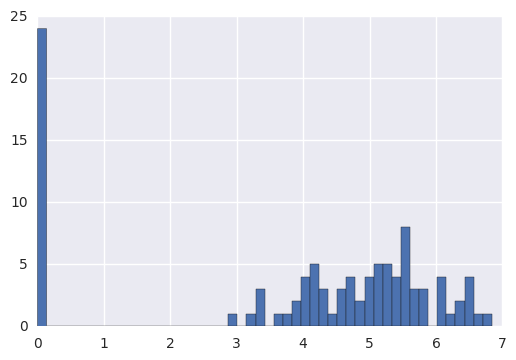

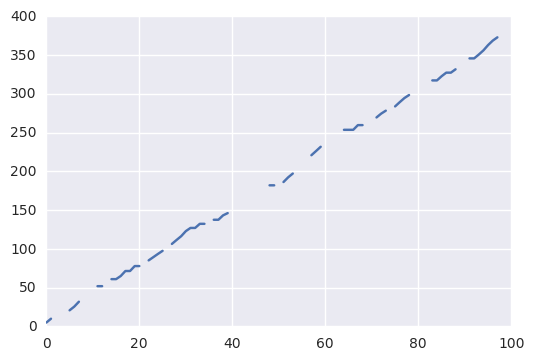

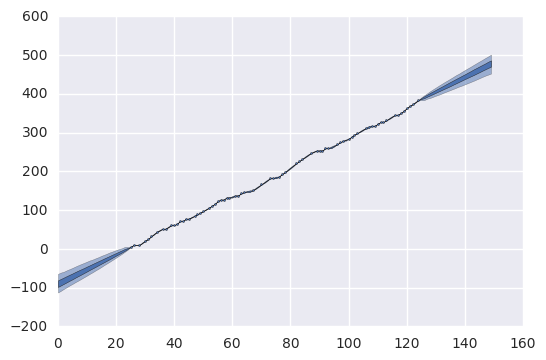

In [17]:
### Random walk, missing data, positive steps, possibility of no step, small noise on no step
p_missing = 0.3
theta = .8
mu = 5
sigma = 1
n = 100

improvement = rand(n)<theta
improvement[0] = True

a = -mu / sigma
simulated_data = truncnorm(a, inf, loc=mu,scale=sigma).rvs(n)
simulated_data[~improvement]=0

simulated_time_series = cumsum(simulated_data)
missing = rand(n)<p_missing
missing[0] = False
missing[-1] = False
simulated_time_series[missing]=nan


hist(simulated_data, bins=50)
figure()
plot(simulated_time_series)



n_past_steps = 25
n_future_steps = 25
stan_data = {'N_time_periods': len(simulated_time_series)+n_future_steps+n_past_steps,
            'N_time_periods_for_inference': len(simulated_time_series)+n_past_steps,
             'Y': pd.Series(concatenate((empty(n_past_steps)*nan,
                                         simulated_time_series,
                                         empty(n_future_steps)*nan),0)).fillna(-999),
           'theta_prior_location': .8,
           'theta_prior_scale': 2,
            'mu_prior_location': 3,
            'mu_prior_scale': 1,
            'sigma_prior_location': 1,
            'sigma_prior_scale': 2}

model_fit = stanity.fit(model_code['improvement~bernoulli(theta)N(mu,sigma)'], data=stan_data, n_jobs=n_jobs)

print(_print_stanfit(model_fit, ['mu', 'sigma','theta']))

print("mu: %.2f, inferred mu: %.2f"%(mu, model_fit['mu'].mean()))
print("sigma: %.2f, inferred sigma: %.2f"%(sigma, model_fit['sigma'].mean()))
print("theta: %.2f, inferred theta: %.2f"%(theta, model_fit['theta'].mean()))

figure()
plot_time_series_inference(model_fit)
scatter(arange(len(simulated_time_series))+n_past_steps, simulated_time_series,s=2)
xlim(xmin=0)
# ylim(ymin=0)

Define Multiple Time-Series Models (pooled and unpooled) and Ensure They Correctly Fit to Simulated Data
===

Create building blocks
---

In [18]:
multiple_data_string = """
int N_technologies;
int N_time_periods; // number of time periods
vector[N_time_periods] Y[N_technologies]; // value each time period

int N_time_periods_for_inference;
%(priors)s
"""

multiple_transformed_data_string="""
int first_observation[N_technologies];
int last_observation[N_technologies];
int N_observed_time_periods_for_inference[N_technologies];
int r_observation_offset[N_technologies];
int n_observations[N_technologies];
int r_array_offset[N_technologies];

for (tech in 1:N_technologies){
  first_observation[tech] = first_observation_ind(Y[tech][1:N_time_periods_for_inference]);
  last_observation[tech] = last_observation_ind(Y[tech][1:N_time_periods_for_inference], 
                      N_time_periods_for_inference);

  N_observed_time_periods_for_inference[tech] = last_observation[tech]-first_observation[tech] + 1;
  r_observation_offset[tech] = first_observation[tech]-1;
  n_observations[tech] = count_n_observations(Y[tech]);
}
r_array_offset[1] = 0;
for (tech in 2:N_technologies){
    r_array_offset[tech] = N_observed_time_periods_for_inference[tech-1]+r_array_offset[tech-1]-1;
}
"""

multiple_parameters_string="""
vector<lower = 0,upper = 1>[sum(N_observed_time_periods_for_inference)-N_technologies] r_raw; // updates
%(parameters)s
"""

multiple_transformed_parameters_string="""
// Identify where the first and last non-missing data points are in Y
vector<lower = 0>[sum(N_observed_time_periods_for_inference)-
                            N_technologies] r; // updates

{
// Dictate that the total change between each pair of observations is equal to the observed change between them
// This is relevant for time periods with missing data
int most_recent_observation;
for (tech in 1:N_technologies){
  most_recent_observation = first_observation[tech];
  for(t in first_observation[tech]+1:last_observation[tech]) {
      if(Y[tech][t] > -900) {
        r[(r_array_offset[tech]+most_recent_observation-r_observation_offset[tech]):
          (r_array_offset[tech]+(t-1)-r_observation_offset[tech])] = 
        r_raw[(r_array_offset[tech]+most_recent_observation-r_observation_offset[tech]):
          (r_array_offset[tech]+(t-1)-r_observation_offset[tech])] /
        sum(r_raw[(r_array_offset[tech]+most_recent_observation-r_observation_offset[tech]):
          (r_array_offset[tech]+(t-1)-r_observation_offset[tech])]) * 
        (Y[tech][t]-Y[tech][most_recent_observation]);
        most_recent_observation = t;
        }
    }
  }
}
"""

multiple_generated_quantities_string = """
vector[N_time_periods] Y_sim[N_technologies];
vector[N_time_periods_for_inference] log_likelihood[N_technologies];
//real mean_change[N_technologies];
//real variance_change[N_technologies];

//for (tech in 1:N_technologies){
//    mean_change = mean(r[r_array_offset[tech]:(r_array_offset[tech]+N_observed_time_periods_for_inference[tech])]);
//    variance_change = variance(r[r_array_offset[tech]:(r_array_offset[tech]+N_observed_time_periods_for_inference[tech])]);
//}

//Fill out data in the missing periods
for (tech in 1:N_technologies){
    for(t in first_observation[tech]:last_observation[tech]) {
      if(Y[tech][t] > -900){
          Y_sim[tech][t] = Y[tech][t];
      } else{
          Y_sim[tech][t] = Y_sim[tech][t-1] + r[r_array_offset[tech]+(t-1)-r_observation_offset[tech]];
      } 
    }
}
{
real increase_size;
//Fill out future data points
for (tech in 1:N_technologies){
    for(t in last_observation[tech]+1:N_time_periods){
        // Stan cannot yet generate numbers from a truncated distribution directly, so we have to do this silly thing. 
        // As of version 2.12.0, the devs are still talking about it: https://github.com/stan-dev/math/issues/214
        increase_size = -1.0;  
        while (increase_size<0){
            increase_size = %(increase_size)s;
        }
        Y_sim[tech][t] = increase_size + Y_sim[tech][t-1];
    }
}
}

//Fill out past data points
{
int t;
real increase_size;
for (tech in 1:N_technologies){
    t = first_observation[tech];
    while(t>1){
        increase_size = -1.0;  
        while (increase_size<0){
            increase_size = %(increase_size)s;
        }
        Y_sim[tech][t-1] = Y_sim[tech][t] - increase_size;
        t = t-1;
    }
}
}

for (tech in 1:N_technologies){
    for(t in 2:N_time_periods_for_inference){
        if(Y[tech][t] > -900){
                %(log_likelihood)s
        }
    }
}
"""

multiple_model_string = """
functions{
%(functions_string)s
}

data {
%(data_string)s
}

transformed data {
%(transformed_data_string)s
}
  
parameters {
%(parameters_string)s
}

transformed parameters {
%(transformed_parameters_string)s
}

model {
%(model_string)s
}

generated quantities {
%(generated_quantities_string)s
}
"""%{
'functions_string': functions_string,
'data_string': multiple_data_string,
'transformed_data_string': multiple_transformed_data_string,
'parameters_string': multiple_parameters_string,
'transformed_parameters_string': multiple_transformed_parameters_string,
'model_string': '%(model)s',
'generated_quantities_string': multiple_generated_quantities_string}

Define models
---

In [19]:
###### improvement~N(mu,sigma), multiple (unpooled)

model_code['improvement~N(mu,sigma), multiple'] = multiple_model_string%{
    'model': """
            mu ~ normal(mu_prior_location, mu_prior_scale);
            sigma ~ cauchy(sigma_prior_location, sigma_prior_scale);

            for (tech in 1:N_technologies){
                for(t in 1:N_observed_time_periods_for_inference[tech]-1){
                    target += lower_truncated_normal_lpdf(r[r_array_offset[tech]+t] | mu[tech], sigma[tech], 0);
                }
            }""",
    'parameters': """
                real<lower = 0> mu[N_technologies];
                real<lower = 0> sigma[N_technologies];
                """,
    'increase_size': 'normal_rng(mu[tech],sigma[tech])',
    'log_likelihood': """
                    log_likelihood[tech][t] = lower_truncated_normal_lpdf(Y[tech][t]-
                                                                    Y_sim[tech][t-1]| mu[tech], sigma[tech], 0);;
                """,
    'priors': """
            real mu_prior_location;
            real mu_prior_scale;

            real sigma_prior_location;
            real sigma_prior_scale;
            """}




###### improvement~N(mu,sigma), hierarchical
model_code['improvement~N(mu,sigma), hierarchical'] = multiple_model_string%{
    'model': """
            tau ~ cauchy(0, 2);
            L_Omega ~ lkj_corr_cholesky(1);
            mu_mu ~ normal(mu_prior_location, mu_prior_scale);
            mu_sigma ~ cauchy(sigma_prior_location, sigma_prior_scale);
            
            {
            matrix[N_technologies, 2] parvec;
            vector[2] mu_parvec;

            parvec = append_col(mu, sigma);
            mu_parvec[1] = mu_mu;
            mu_parvec[2] = mu_sigma;
            
            for (tech in 1:N_technologies){

                log(parvec[tech]) ~ multi_normal_cholesky(log(mu_parvec), diag_pre_multiply(tau, L_Omega));
                for(t in 1:N_observed_time_periods_for_inference[tech]-1){
                    target += lower_truncated_normal_lpdf(r[r_array_offset[tech]+t] | mu[tech], sigma[tech], 0);
                }
            }
            }""",
    'parameters': """
                vector<lower = 0>[N_technologies] mu;
                vector<lower = 0>[N_technologies] sigma;
                
                cholesky_factor_corr[2] L_Omega;
                vector<lower = 0>[2] tau;
                
                real<lower = 0> mu_mu;
                real<lower = 0> mu_sigma;
                """,
    'increase_size': 'normal_rng(mu[tech],sigma[tech])',
    'log_likelihood': """
                    log_likelihood[tech][t] = lower_truncated_normal_lpdf(Y[tech][t]-
                                                                    Y_sim[tech][t-1]| mu[tech], sigma[tech], 0);
                """,
    'priors': """
            real mu_prior_location;
            real mu_prior_scale;

            real sigma_prior_location;
            real sigma_prior_scale;
            """}


###### improvement~logN(mu,sigma), hierarchical
model_code['improvement~logN(mu,sigma), hierarchical'] = multiple_model_string%{
    'model': """
            tau ~ cauchy(0, 2);
            //Omega ~ lkj_corr(1);
            L_Omega ~ lkj_corr_cholesky(1);
            //z ~ normal(0,1);
            mu_mu ~ normal(mu_prior_location, mu_prior_scale);
            mu_sigma ~ cauchy(sigma_prior_location, sigma_prior_scale);
            
            {
            matrix[N_technologies, 2] parvec;
            vector[2] mu_parvec;

            parvec = append_col(mu, log(sigma));
            mu_parvec[1] = mu_mu;
            mu_parvec[2] = log(mu_sigma);
            
            for (tech in 1:N_technologies){
                //parvec[tech] ~ multi_normal(mu_parvec, quad_form_diag(Omega, tau));
                //parvec[tech] = (mu_parvec + (diag_pre_multiply(tau,L_Omega) * z))';
                parvec[tech] ~ multi_normal_cholesky(mu_parvec, diag_pre_multiply(tau, L_Omega));
                for(t in 1:N_observed_time_periods_for_inference[tech]-1){
                    target += lognormal_lpdf(r[r_array_offset[tech]+t] | mu[tech], sigma[tech]);
                }
            }
            }""",
    'parameters': """
                vector[N_technologies] mu;
                vector<lower = 0>[N_technologies] sigma;
                
                //corr_matrix[2] Omega;
                cholesky_factor_corr[2] L_Omega;
                vector<lower = 0>[2] tau;
                //vector<lower = 0>[2] z;
                
                real mu_mu;
                real<lower = 0> mu_sigma;
                """,
    'increase_size': 'lognormal_rng(mu[tech],sigma[tech])',
    'log_likelihood': """
                    log_likelihood[tech][t] = lognormal_lpdf(Y[tech][t]-
                                                                    Y_sim[tech][t-1]| mu[tech], sigma[tech]);
                """,
    'priors': """
            real mu_prior_location;
            real mu_prior_scale;

            real sigma_prior_location;
            real sigma_prior_scale;
            """}

###### improvement~logN(mu,sigma), multiple
model_code['improvement~logN(mu,sigma), multiple'] = multiple_model_string%{
    'model': """
            mu ~ normal(mu_prior_location, mu_prior_scale);
            sigma ~ cauchy(sigma_prior_location, sigma_prior_scale);
            
            for (tech in 1:N_technologies){
                for(t in 1:N_observed_time_periods_for_inference[tech]-1){
                    target += lognormal_lpdf(r[r_array_offset[tech]+t] | mu[tech], sigma[tech]);
                }
            }""",
    'parameters': """
                vector[N_technologies] mu;
                vector<lower = 0>[N_technologies] sigma;
                """,
    'increase_size': 'lognormal_rng(mu[tech],sigma[tech])',
    'log_likelihood': """
                    log_likelihood[tech][t] = lognormal_lpdf(Y[tech][t]-
                                                                    Y_sim[tech][t-1]| mu[tech], sigma[tech]);
                """,
    'priors': """
            real mu_prior_location;
            real mu_prior_scale;

            real sigma_prior_location;
            real sigma_prior_scale;
            """}

###### improvement~bernoulli(theta)N(mu,sigma), multiple
model_code['improvement~bernoulli(theta)N(mu,sigma), multiple'] = multiple_model_string%{
    'model': """

            mu ~ normal(mu_prior_location, mu_prior_scale);
            sigma ~ cauchy(sigma_prior_location, sigma_prior_scale);
            theta ~ normal(theta_prior_location, theta_prior_scale);

            for (tech in 1:N_technologies){
                for(t in 1:N_observed_time_periods_for_inference[tech]-1){
                    target += log_mix(theta[tech], 
                              lower_truncated_normal_lpdf(r[r_array_offset[tech]+t] | mu[tech], sigma[tech], 0), 
                              lower_truncated_normal_lpdf(r[r_array_offset[tech]+t] | 0, 0.01, 0));
                }
            }""",
    'parameters': """
                vector<lower = 0>[N_technologies] mu;
                vector<lower = 0>[N_technologies] sigma;
                vector<lower = 0, upper = 1>[N_technologies] theta;
                
                """,
    'increase_size': 'bernoulli_rng(theta[tech]) * normal_rng(mu[tech],sigma[tech])',
    'log_likelihood': """
                    if((Y[tech][t]-Y_sim[tech][t-1])==0) {
                        log_likelihood[tech][t] = log(1-theta[tech]);
                    } else {
                        log_likelihood[tech][t] = log(theta[tech]) + 
                        lower_truncated_normal_lpdf(Y[tech][t]-Y_sim[tech][t-1]| mu[tech], sigma[tech], 0);
                    }
                """,
    'priors': """
            real mu_prior_location;
            real mu_prior_scale;

            real sigma_prior_location;
            real sigma_prior_scale;
            
            real theta_prior_location;
            real theta_prior_scale;
            """}

###### improvement~bernoulli(theta)N(mu,sigma), hierarchical
model_code['improvement~bernoulli(theta)N(mu,sigma), hierarchical'] = multiple_model_string%{
    'model': """
            tau ~ cauchy(0, 2);
            L_Omega ~ lkj_corr_cholesky(1);
            mu_mu ~ normal(mu_prior_location, mu_prior_scale);
            mu_sigma ~ cauchy(sigma_prior_location, sigma_prior_scale);
            mu_theta ~ normal(theta_prior_location, theta_prior_scale);

            
            {
            matrix[N_technologies, 3] parvec;
            vector[3] mu_parvec;

            parvec = append_col(mu, append_col(sigma, theta));
            mu_parvec[1] = mu_mu;
            mu_parvec[2] = mu_sigma;
            mu_parvec[3] = mu_theta;
            
            for (tech in 1:N_technologies){

                parvec[tech] ~ multi_normal_cholesky(mu_parvec, diag_pre_multiply(tau, L_Omega));
                for(t in 1:N_observed_time_periods_for_inference[tech]-1){
                    target += log_mix(theta[tech], 
                              lower_truncated_normal_lpdf(r[r_array_offset[tech]+t] | mu[tech], sigma[tech], 0), 
                              lower_truncated_normal_lpdf(r[r_array_offset[tech]+t] | 0, 0.01, 0));
                }
            }
            }""",
    'parameters': """
                vector<lower = 0>[N_technologies] mu;
                vector<lower = 0>[N_technologies] sigma;
                vector<lower = 0, upper = 1>[N_technologies] theta;
                
                cholesky_factor_corr[3] L_Omega;
                vector<lower = 0>[3] tau;
                
                real<lower = 0> mu_mu;
                real<lower = 0> mu_sigma;
                real<lower = 0, upper = 1> mu_theta;
                
                """,
    'increase_size': 'bernoulli_rng(theta[tech]) * normal_rng(mu[tech],sigma[tech])',
    'log_likelihood': """
                    if((Y[tech][t]-Y_sim[tech][t-1])==0) {
                        log_likelihood[tech][t] = log(1-theta[tech]);
                    } else {
                        log_likelihood[tech][t] = log(theta[tech]) + 
                        lower_truncated_normal_lpdf(Y[tech][t]-Y_sim[tech][t-1]| mu[tech], sigma[tech], 0);
                    }
                """,
    'priors': """
            real mu_prior_location;
            real mu_prior_scale;

            real sigma_prior_location;
            real sigma_prior_scale;
            
            real theta_prior_location;
            real theta_prior_scale;
            """}

###### improvement~bernoulli(theta)logN(mu,sigma), hierarchical
model_code['improvement~bernoulli(theta)logN(mu,sigma), hierarchical'] = multiple_model_string%{
    'model': """
            tau ~ cauchy(0, 2);
            L_Omega ~ lkj_corr_cholesky(1);
            mu_mu ~ normal(mu_prior_location, mu_prior_scale);
            mu_sigma ~ cauchy(sigma_prior_location, sigma_prior_scale);
            mu_theta ~ normal(theta_prior_location, theta_prior_scale);

            
            {
            matrix[N_technologies, 3] parvec;
            vector[3] mu_parvec;

            parvec = append_col(mu, append_col(sigma, theta));
            mu_parvec[1] = mu_mu;
            mu_parvec[2] = mu_sigma;
            mu_parvec[3] = mu_theta;
            
            for (tech in 1:N_technologies){

                parvec[tech] ~ multi_normal_cholesky(mu_parvec, diag_pre_multiply(tau, L_Omega));
                for(t in 1:N_observed_time_periods_for_inference[tech]-1){
                    target += log_mix(theta[tech], 
                              lognormal_lpdf(r[r_array_offset[tech]+t] | mu[tech], sigma[tech]), 
                              lognormal_lpdf(r[r_array_offset[tech]+t] | 0, 0.01));
                }
            }
            }""",
    'parameters': """
                vector[N_technologies] mu;
                vector<lower = 0>[N_technologies] sigma;
                vector<lower = 0, upper = 1>[N_technologies] theta;
                
                cholesky_factor_corr[3] L_Omega;
                vector<lower = 0>[3] tau;
                
                real mu_mu;
                real<lower = 0> mu_sigma;
                real<lower = 0, upper = 1> mu_theta;
                
                """,
    'increase_size': 'bernoulli_rng(theta[tech]) * lognormal_rng(mu[tech],sigma[tech])',
    'log_likelihood': """
                    if((Y[tech][t]-Y_sim[tech][t-1])==0) {
                        log_likelihood[tech][t] = log(1-theta[tech]);
                    } else {
                        log_likelihood[tech][t] = log(theta[tech]) + 
                        lognormal_lpdf(Y[tech][t]-Y_sim[tech][t-1]| mu[tech], sigma[tech]);
                    }
                """,
    'priors': """
            real mu_prior_location;
            real mu_prior_scale;

            real sigma_prior_location;
            real sigma_prior_scale;
            
            real theta_prior_location;
            real theta_prior_scale;
            """}

###### improvement~bernoulli(theta)logN(mu,sigma), multiple
model_code['improvement~bernoulli(theta)logN(mu,sigma), multiple'] = multiple_model_string%{
    'model': """
            mu ~ normal(mu_prior_location, mu_prior_scale);
            sigma ~ cauchy(sigma_prior_location, sigma_prior_scale);
            theta ~ normal(theta_prior_location, theta_prior_scale);

            for (tech in 1:N_technologies){
                for(t in 1:N_observed_time_periods_for_inference[tech]-1){
                    target += log_mix(theta[tech], 
                              lognormal_lpdf(r[r_array_offset[tech]+t] | mu[tech], sigma[tech]), 
                              lognormal_lpdf(r[r_array_offset[tech]+t] | 0, 0.01));
                }
            }""",
    'parameters': """
                vector[N_technologies] mu;
                vector<lower = 0>[N_technologies] sigma;
                vector<lower = 0, upper = 1>[N_technologies] theta;
 
                
                """,
    'increase_size': 'bernoulli_rng(theta[tech]) * lognormal_rng(mu[tech],sigma[tech])',
    'log_likelihood': """
                    if((Y[tech][t]-Y_sim[tech][t-1])==0) {
                        log_likelihood[tech][t] = log(1-theta[tech]);
                    } else {
                        log_likelihood[tech][t] = log(theta[tech]) + 
                        lognormal_lpdf(Y[tech][t]-Y_sim[tech][t-1]| mu[tech], sigma[tech]);
                    }
                """,
    'priors': """
            real mu_prior_location;
            real mu_prior_scale;

            real sigma_prior_location;
            real sigma_prior_scale;
            
            real theta_prior_location;
            real theta_prior_scale;
            """}

In [20]:
model_code['improvement~N(mu,sigma), multiple vectorized'] = """
functions{
    
int first_observation_ind(vector my_array){
    int t;
    t = 1;
    while(my_array[t] < -900){
      t = t+1;
    }
    return t;
}

int last_observation_ind(vector my_array, int length){
    int last_observation;
    last_observation = 0; 
    for(t in 1:length){
      if(my_array[t] > -900){
          last_observation = t;
      }
    }
    return last_observation;
}


int count_n_observations(vector my_array) {
    int count;
    count = 0;
    for (t in 1:num_elements(my_array)) {
        if(my_array[t] > -900){
            count = count + 1;
        }
    }
    return count;
}

real lower_truncated_normal_lpdf(real x, real mu, real sigma, real A) {
    return(normal_lpdf(x | mu, sigma) - normal_lccdf(A | mu, sigma));
}

real lower_truncated_normal_lpdf_vector(vector x, vector mu, vector sigma, real A) {
    return(normal_lpdf(x | mu, sigma) - normal_lccdf(A | mu, sigma));
}

}

data {

int N_technologies;
int N_time_periods; // number of time periods
vector[N_time_periods] Y[N_technologies]; // value each time period

int N_time_periods_for_inference;

            real mu_prior_location;
            real mu_prior_scale;

            real sigma_prior_location;
            real sigma_prior_scale;
            

}

transformed data {

int first_observation[N_technologies];
int last_observation[N_technologies];
int N_observed_time_periods_for_inference[N_technologies];
int r_observation_offset[N_technologies];
int n_observations[N_technologies];
int r_array_offset[N_technologies];
int N_r;

for (tech in 1:N_technologies){
  first_observation[tech] = first_observation_ind(Y[tech][1:N_time_periods_for_inference]);
  last_observation[tech] = last_observation_ind(Y[tech][1:N_time_periods_for_inference], 
                      N_time_periods_for_inference);

  N_observed_time_periods_for_inference[tech] = last_observation[tech]-first_observation[tech] + 1;
  r_observation_offset[tech] = first_observation[tech]-1;
  n_observations[tech] = count_n_observations(Y[tech]);
}
r_array_offset[1] = 0;
for (tech in 2:N_technologies){
    r_array_offset[tech] = N_observed_time_periods_for_inference[tech-1]+r_array_offset[tech-1]-1;
}

N_r = sum(N_observed_time_periods_for_inference)-N_technologies;

//int tech_of_each_update[N_r];
//for (tech in 1:N_technologies-1){
//    for(r_ind in r_array_offset[tech]+1:r_array_offset[tech+1]){
//        tech_of_each_update[r_ind] = tech;
//    }
//}
//for(r_ind in r_array_offset[N_technologies]+1:N_r){
//        tech_of_each_update[r_ind] = N_technologies;
//    }
//
}
  
parameters {

vector<lower = 0,upper = 1>[N_r] r_raw; // updates

vector<lower = 0>[N_technologies] mu;
vector<lower = 0>[N_technologies] sigma;
                

}

transformed parameters {

// Identify where the first and last non-missing data points are in Y
vector<lower = 0>[N_r] r; // updates

vector<lower = 0>[N_r] r_mu; // updates parameter 1  
vector<lower = 0>[N_r] r_sigma; // updates parameter 2
for (tech in 1:N_technologies-1){
    for(r_ind in r_array_offset[tech]+1:r_array_offset[tech+1]){
        r_mu[r_ind] = mu[tech];
        r_sigma[r_ind] = sigma[tech];        
    }
}
for(r_ind in r_array_offset[N_technologies]+1:N_r){
        r_mu[r_ind] = mu[N_technologies];
        r_sigma[r_ind] = sigma[N_technologies];        
    }
//r_mu = mu[tech_of_each_update];
//r_sigma = sigma[tech_of_each_update];

//for (tech in 1:N_technologies-1){
//    mus[r_array_offset[tech]+1:r_array_offset[tech+1]] = mu[tech];
//    sigmas[r_array_offset[tech]+1:r_array_offset[tech+1]] = sigma[tech];
//}
//mus[r_array_offset[N_technologies]+1:size(mus)] = mu[N_technologies];
//sigmas[r_array_offset[N_technologies]+1:size(sigmas)] = sigma[N_technologies];

{
// Dictate that the total change between each pair of observations is equal to the observed change between them
// This is relevant for time periods with missing data
int most_recent_observation;
for (tech in 1:N_technologies){
  most_recent_observation = first_observation[tech];
  for(t in first_observation[tech]+1:last_observation[tech]) {
      if(Y[tech][t] > -900) {
        r[(r_array_offset[tech]+most_recent_observation-r_observation_offset[tech]):
          (r_array_offset[tech]+(t-1)-r_observation_offset[tech])] = 
        r_raw[(r_array_offset[tech]+most_recent_observation-r_observation_offset[tech]):
          (r_array_offset[tech]+(t-1)-r_observation_offset[tech])] /
        sum(r_raw[(r_array_offset[tech]+most_recent_observation-r_observation_offset[tech]):
          (r_array_offset[tech]+(t-1)-r_observation_offset[tech])]) * 
        (Y[tech][t]-Y[tech][most_recent_observation]);
        most_recent_observation = t;
        }
    }
  }
}



}

model {

            mu ~ normal(mu_prior_location, mu_prior_scale);
            sigma ~ cauchy(sigma_prior_location, sigma_prior_scale);
            //r ~ normal(r_mu,r_sigma) T[0,];
            target += lower_truncated_normal_lpdf_vector(r, r_mu, r_sigma, 0);
            
}

generated quantities {

vector[N_time_periods] Y_sim[N_technologies];
vector[N_time_periods_for_inference] log_likelihood[N_technologies];

//Fill out data in the missing periods
for (tech in 1:N_technologies){
    for(t in first_observation[tech]:last_observation[tech]) {
      if(Y[tech][t] > -900){
          Y_sim[tech][t] = Y[tech][t];
      } else{
          Y_sim[tech][t] = Y_sim[tech][t-1] + r[r_array_offset[tech]+(t-1)-r_observation_offset[tech]];
      } 
    }
}
{
real increase_size;
//Fill out future data points
for (tech in 1:N_technologies){
    for(t in last_observation[tech]+1:N_time_periods){
        // Stan cannot yet generate numbers from a truncated distribution directly, so we have to do this silly thing. 
        // As of version 2.12.0, the devs are still talking about it: https://github.com/stan-dev/math/issues/214
        increase_size = -1.0;  
        while (increase_size<0){
            increase_size = normal_rng(mu[tech],sigma[tech]);
        }
        Y_sim[tech][t] = increase_size + Y_sim[tech][t-1];
    }
}
}

//Fill out past data points
{
int t;
real increase_size;
for (tech in 1:N_technologies){
    t = first_observation[tech];
    while(t>1){
        increase_size = -1.0;  
        while (increase_size<0){
            increase_size = normal_rng(mu[tech],sigma[tech]);
        }
        Y_sim[tech][t-1] = Y_sim[tech][t] - increase_size;
        t = t-1;
    }
}
}

for (tech in 1:N_technologies){
    for(t in 2:N_time_periods_for_inference){
        if(Y[tech][t] > -900){
                
                    log_likelihood[tech][t] = lower_truncated_normal_lpdf(Y[tech][t]-
                                                                    Y_sim[tech][t-1]| mu[tech], sigma[tech], 0);;
                
        }
    }
}

}
"""

Test on simulated data
---

Normal
---

In [ ]:
### Random walk, missing data, positive steps, multiple technologies
mu_mu = .3
mu_sigma = .5

Omega = matrix([[1,.7],
               [.7,1]])
tau = array([1,1])
cov = diag(tau)*Omega*diag(tau)

p_missing = 0
n = 100
N_technologies = 50

mus = zeros(N_technologies)
sigmas = zeros(N_technologies)

simulated_time_series = empty((n, N_technologies))
for i in arange(N_technologies):
    while mus[i]==0:
        mu, sigma = multivariate_normal(array([mu_mu, mu_sigma]), cov=cov).rvs(1)
        if mu>0 and sigma>0:
            mus[i] = mu
            sigmas[i] = sigma
    a = -mu / sigma
    simulated_data = truncnorm(a, inf, loc=mu,scale=sigma).rvs(n)
    simulated_time_series[:,i] = cumsum(simulated_data)
    missing = rand(n)<p_missing
    simulated_time_series[missing,i]=nan


stan_data = {'N_technologies': N_technologies,
            'N_time_periods': n,
            'N_time_periods_for_inference': n,
             'Y': pd.DataFrame(simulated_time_series).T.fillna(-999).values,
            'mu_prior_location': .1,
            'mu_prior_scale': 1,
            'sigma_prior_location': 0,
            'sigma_prior_scale': 2}

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_3ae2a6ff04202b9a26949f5c45b9c463 NOW.


NOT reusing model.
Ran in 1082.186 sec.
0.98
0.94
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu[0]       0.69  9.1e-3   0.26   0.08   0.54   0.73   0.88    1.1    799   1.01
mu[1]       0.85  2.6e-4   0.02   0.82   0.84   0.85   0.86   0.88   4000    1.0
mu[2]       0.45  5.0e-3   0.21   0.05    0.3   0.47   0.61   0.81   1705    1.0
mu[3]       0.91  7.8e-3   0.34   0.16    0.7   0.96   1.17   1.46   1891    1.0
mu[4]       1.17  1.2e-3   0.08   1.01   1.12   1.17   1.22    1.3   4000    1.0
mu[5]       2.01    0.01    0.4   1.02    1.8   2.07   2.28   2.61   1421    1.0
mu[6]       2.58  7.0e-3   0.29   1.89   2.43   2.62   2.79   3.05   1706    1.0
mu[7]       0.25  3.4e-3   0.19 8.6e-3    0.1   0.22   0.37   0.68   2980    1.0
mu[8]       0.37  4.9e-3   0.17   0.03   0.25   0.39    0.5   0.66   1240    1.0
mu[9]       1.11  2.2e

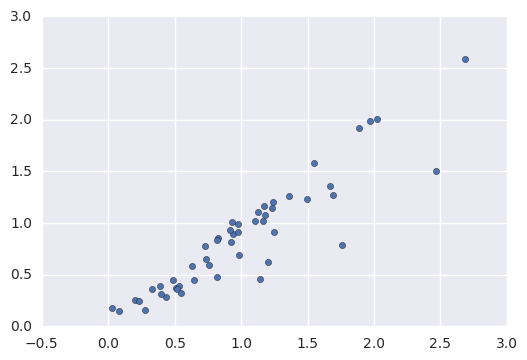

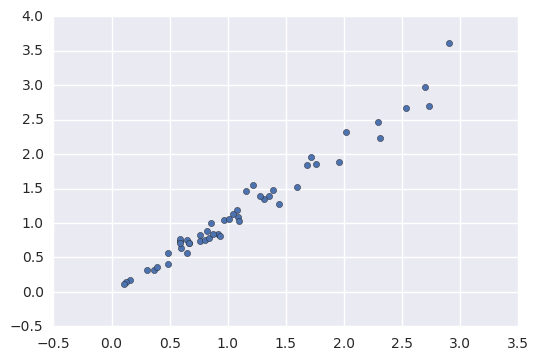

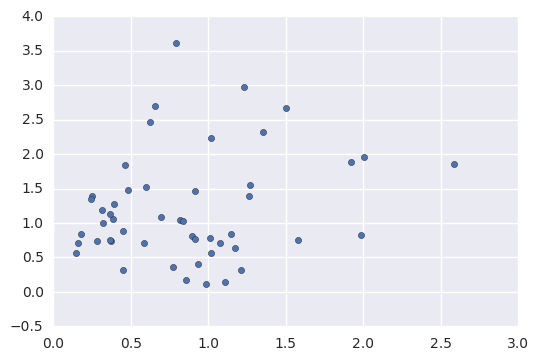

In [21]:
model_fit = stanity.fit(model_code['improvement~N(mu,sigma), multiple'], data=stan_data, n_jobs=n_jobs)

print(portion_of_data_within_CI(model_fit, 'mu', mus, 2.5, 97.5))
print(portion_of_data_within_CI(model_fit, 'sigma', sigmas, 2.5, 97.5))

print(_print_stanfit(model_fit, ['mu', 'sigma']))


scatter(mus,
        model_fit['mu'].mean(axis=0)
       )
figure()
scatter(sigmas,
        model_fit['sigma'].mean(axis=0)
       )
figure()
scatter(model_fit['mu'].mean(axis=0),
        model_fit['sigma'].mean(axis=0)
       )

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_1182073d1573262bdd7ca722e1507dec NOW.


NOT reusing model.
Ran in 804.161 sec.
0.92
0.9
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu[0]       0.81  2.8e-3   0.18   0.43    0.7   0.83   0.94   1.12   4000    1.0
mu[1]       0.85  2.6e-4   0.02   0.82   0.84   0.85   0.86   0.88   4000    1.0
mu[2]       0.59  2.1e-3   0.13   0.32    0.5    0.6   0.69   0.84   4000    1.0
mu[3]       1.04  4.3e-3   0.26    0.5   0.87   1.06   1.23   1.49   3707    1.0
mu[4]       1.17  1.2e-3   0.08    1.0   1.12   1.17   1.22    1.3   4000    1.0
mu[5]        2.1  7.1e-3   0.35   1.24   1.92   2.16   2.35   2.64   2459    1.0
mu[6]       2.68  4.1e-3   0.26    2.1   2.53   2.71   2.85   3.11   4000    1.0
mu[7]       0.53  2.5e-3   0.16   0.25   0.41   0.52   0.64   0.86   4000    1.0
mu[8]        0.5  1.7e-3   0.11   0.28   0.43   0.51   0.58    0.7   4000    1.0
mu[9]       1.11  2.2e-4

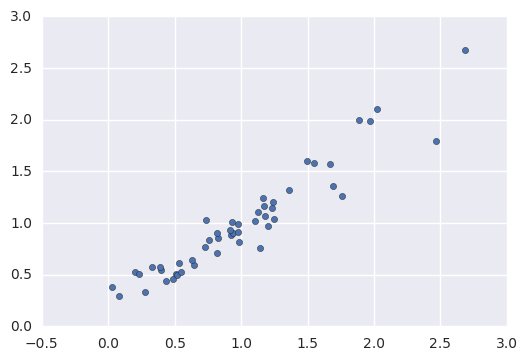

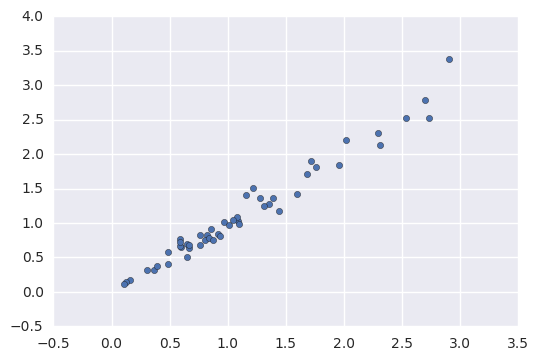

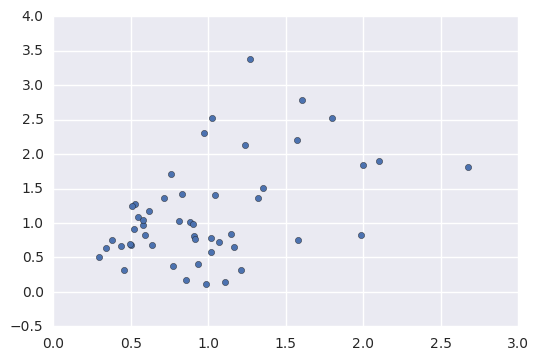

In [22]:
model_fit = stanity.fit(model_code['improvement~N(mu,sigma), hierarchical'], data=stan_data, n_jobs=n_jobs)

print(portion_of_data_within_CI(model_fit, 'mu', mus, 2.5, 97.5))
print(portion_of_data_within_CI(model_fit, 'sigma', sigmas, 2.5, 97.5))

print(_print_stanfit(model_fit, ['mu', 'sigma']))

print(mean(calculate_Omega_from_L_Omega(model_fit),axis=0))

print(_print_stanfit(model_fit, ['mu', 'sigma', 'L_Omega', 'tau']))

scatter(mus,
        model_fit['mu'].mean(axis=0)
       )
figure()
scatter(sigmas,
        model_fit['sigma'].mean(axis=0)
       )
figure()
scatter(model_fit['mu'].mean(axis=0),
        model_fit['sigma'].mean(axis=0)
       )

Lognormal
---

In [33]:
### Random walk, missing data, lognormal steps, multiple technologies, hierarchical
mu_mu = .3
mu_sigma = .5

Omega = matrix([[1,.7],
               [.7,1]])
tau = array([1,1])
cov = diag(tau)*Omega*diag(tau)

p_missing = 0
n = 100
N_technologies = 5

mus = zeros(N_technologies)
sigmas = zeros(N_technologies)

simulated_time_series = empty((n, N_technologies))
for i in arange(N_technologies):
    while mus[i]==0:
        mu, sigma = multivariate_normal(array([mu_mu, mu_sigma]), cov=cov).rvs(1)
        if sigma>0:
            mus[i] = mu
            sigmas[i] = sigma
    simulated_data = lognorm(sigma, scale=exp(mu), loc=0).rvs(n)
    simulated_time_series[:,i] = cumsum(simulated_data)
    missing = rand(n)<p_missing
    simulated_time_series[missing,i]=nan


stan_data = {'N_technologies': N_technologies,
            'N_time_periods': n,
            'N_time_periods_for_inference': n,
             'Y': pd.DataFrame(simulated_time_series).T.fillna(-999).values,
            'mu_prior_location': .1,
            'mu_prior_scale': 1,
            'sigma_prior_location': 0,
            'sigma_prior_scale': 2}

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_b6018ffb5b084e008b246265adc8a63d NOW.


NOT reusing model.
Ran in 105.756 sec.
1.0
1.0
[[ 1.          0.52458956]
 [ 0.52458956  1.        ]]
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu[0]          0.75  3.5e-3   0.22   0.33    0.6   0.75   0.91   1.18   4000    1.0
mu[1]          0.32  1.1e-3   0.07   0.18   0.27   0.32   0.36   0.46   4000    1.0
mu[2]           1.4  1.6e-3    0.1   1.19   1.33    1.4   1.47    1.6   4000    1.0
mu[3]         -0.58  2.0e-4   0.01  -0.61  -0.59  -0.58  -0.57  -0.56   4000    1.0
mu[4]          1.83  2.7e-3   0.17   1.49   1.71   1.83   1.95   2.17   4000    1.0
sigma[0]       2.26  2.6e-3   0.17   1.97   2.14   2.25   2.36   2.61   4000    1.0
sigma[1]       0.69  8.1e-4   0.05    0.6   0.66   0.69   0.72    0.8   4000    1.0
sigma[2]       1.02  1.2e-3   0.07   0.89   0.97   1.02   1.07   1.18   4000    1.0
sigma[3]       0.12  1.4

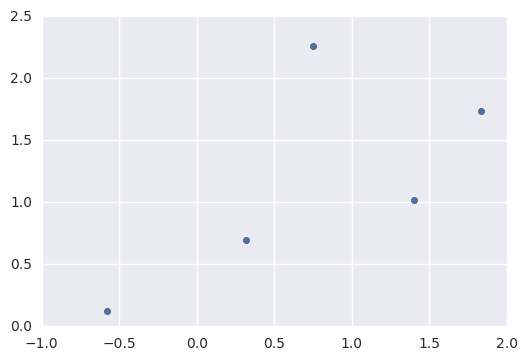

In [34]:
model_fit = stanity.fit(model_code['improvement~logN(mu,sigma), hierarchical'], data=stan_data, n_jobs=n_jobs)


print(portion_of_data_within_CI(model_fit, 'mu', mus, 2.5, 97.5))
print(portion_of_data_within_CI(model_fit, 'sigma', sigmas, 2.5, 97.5))

print(mean(calculate_Omega_from_L_Omega(model_fit),axis=0))

print(_print_stanfit(model_fit, ['mu', 'sigma', 'L_Omega', 'tau']))

scatter(model_fit['mu'].mean(axis=0),
        model_fit['sigma'].mean(axis=0)
       )

Run Time-Series Models on Empirical Performance Data
====

In [35]:
target_tech_names = metadata.ix[metadata['Type']=='Performance', 'Name']
print("%i technologies"%target_tech_names.shape[0])

time_series = log(empirical_data[target_tech_names])

39 technologies


In [36]:
technology_models_log_likelihood = {}
technology_models_parameters = {}

In [37]:
def fit_model_to_data(model_type, model_parameters, parameter_priors, m, v, 
                       time_series=time_series,
                      technology_models_log_likelihood=technology_models_log_likelihood,
                      technology_models_parameters=technology_models_parameters,
                      model_code=model_code,
                      print_output=True
                     ):
    technology_models_log_likelihood[model_type] = pd.Series(index=target_tech_names)

    technology_models_parameters[model_type] = pd.DataFrame(index=target_tech_names,
             columns=model_parameters)


    stan_data = {'N_technologies': time_series.shape[1],
                 'N_time_periods': time_series.shape[0],
            'N_time_periods_for_inference': time_series.shape[0],
             'Y': time_series.fillna(-999).T,
                     }
    stan_data = {**stan_data, **parameter_priors} 

    ###
    model_fit = stanity.fit(model_code[model_type], data=stan_data, n_jobs=n_jobs)
    if print_output:
        print(_print_stanfit(model_fit, model_parameters))

    technology_models_log_likelihood[model_type] = nanmean(nanmean(model_fit['log_likelihood'],axis=0),axis=1)

    for parameter in model_parameters:
        technology_models_parameters[model_type][parameter] = model_fit[parameter].mean(axis=0)


    technology_models_parameters[model_type]['mean']=technology_models_parameters[model_type].apply(m,axis=1)
    technology_models_parameters[model_type]['variance']=technology_models_parameters[model_type].apply(v,axis=1)
    return model_fit

In [38]:
model_type = 'improvement~N(mu,sigma), multiple'
model_parameters = ['mu', 'sigma']
parameter_priors = {'mu_prior_location': 0,
                    'mu_prior_scale': 1,
                    'sigma_prior_location': 0,
                    'sigma_prior_scale': 2,
                }
m = lambda df: truncnorm(0, 10000, loc=df['mu'], scale=df['sigma']).mean()
v = lambda df: truncnorm(0, 10000, loc=df['mu'], scale=df['sigma']).var()

model_fit = fit_model_to_data(model_type, model_parameters, parameter_priors, m, v)

Reusing model.
Ran in 165.508 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu[0]       0.05  6.5e-4   0.02 3.1e-3   0.03   0.05   0.06   0.09   1352    1.0
mu[1]     7.1e-3  9.4e-5 4.3e-3 3.4e-4 3.5e-3 6.9e-3   0.01   0.02   2080    1.0
mu[2]        0.3  3.8e-3   0.12   0.04   0.23   0.33   0.39   0.48    951    1.0
mu[3]       0.15  2.1e-3    0.1 4.8e-3   0.06   0.13   0.22   0.37   2464    1.0
mu[4]       0.05  6.6e-4   0.04 1.5e-3   0.02   0.04   0.07   0.15   4000    1.0
mu[5]       0.15  2.0e-3   0.09 9.8e-3   0.08   0.14   0.22   0.34   2243    1.0
mu[6]       0.04  6.0e-4   0.04 1.2e-3   0.01   0.03   0.06   0.14   4000    1.0
mu[7]       0.17  2.1e-3    0.1 9.5e-3   0.08   0.17   0.24   0.35   2122    1.0
mu[8]       0.01  1.9e-4   0.01 3.7e-4 4.0e-3 9.5e-3   0.02   0.05   4000    1.0
mu[9]       0.26  3.0e-3   0.19   0.0

/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


In [39]:
model_type = 'improvement~N(mu,sigma), hierarchical'
model_parameters = ['mu', 'sigma']
parameter_priors = {'mu_prior_location': .3,
                    'mu_prior_scale': 3,
                    'sigma_prior_location': 0,
                    'sigma_prior_scale': 2,
                }
m = lambda df: truncnorm(0, 10000, loc=df['mu'], scale=df['sigma']).mean()
v = lambda df: truncnorm(0, 10000, loc=df['mu'], scale=df['sigma']).var()

model_fit = fit_model_to_data(model_type, model_parameters, parameter_priors, m, v)

print(mean(calculate_Omega_from_L_Omega(model_fit),axis=0))

Reusing model.
Ran in 169.792 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu[0]       0.02  3.8e-4   0.01 3.5e-3 7.9e-3   0.01   0.02   0.06   1337    1.0
mu[1]     3.8e-3  7.9e-5 2.8e-3 6.7e-4 1.7e-3 3.0e-3 5.1e-3   0.01   1241    1.0
mu[2]       0.13  3.7e-3    0.1   0.02   0.05   0.09   0.17   0.39    716    1.0
mu[3]       0.08  1.8e-3   0.06   0.02   0.04   0.07   0.11   0.25   1138    1.0
mu[4]       0.04  3.9e-4   0.02   0.01   0.03   0.04   0.05   0.11   4000    1.0
mu[5]       0.08  1.7e-3   0.06   0.02   0.04   0.06   0.11   0.24   1221    1.0
mu[6]       0.04  4.0e-4   0.03 9.8e-3   0.02   0.04   0.05   0.11   4000    1.0
mu[7]       0.07  1.5e-3   0.06   0.02   0.03   0.05   0.09   0.24   1396    1.0
mu[8]       0.02  1.7e-4   0.01 5.3e-3   0.01   0.02   0.03   0.05   4000    1.0
mu[9]       0.15  1.8e-3   0.12   0.0

/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


[[ 1.          0.80983219]
 [ 0.80983219  1.        ]]


In [40]:
model_type = 'improvement~logN(mu,sigma), hierarchical'
model_parameters = ['mu', 'sigma']
parameter_priors = {'mu_prior_location': 0,
                    'mu_prior_scale': 1,
                    'sigma_prior_location': 0,
                    'sigma_prior_scale': 2,
                }
m = lambda df: lognorm(df['sigma'], scale=exp(df['mu']), loc=0).mean()
v = lambda df: lognorm(df['sigma'], scale=exp(df['mu']), loc=0).var()

model_fit = fit_model_to_data(model_type, model_parameters, parameter_priors, m, v)
print(mean(calculate_Omega_from_L_Omega(model_fit),axis=0))

Reusing model.
Ran in 152.885 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu[0]       -2.7  2.4e-3   0.15   -3.0   -2.8   -2.7   -2.6  -2.39   4000    1.0
mu[1]       -4.4  2.2e-3   0.14  -4.67  -4.49  -4.39   -4.3  -4.13   4000    1.0
mu[2]      -0.98  1.6e-3    0.1  -1.18  -1.04  -0.97  -0.91  -0.78   4000    1.0
mu[3]      -1.21  2.3e-3   0.15  -1.53   -1.3   -1.2  -1.11  -0.93   4000    1.0
mu[4]      -1.88  2.4e-3   0.15  -2.19  -1.97  -1.87  -1.77   -1.6   4000    1.0
mu[5]      -1.38  2.5e-3   0.16  -1.72  -1.48  -1.38  -1.27  -1.08   4000    1.0
mu[6]      -2.01  2.8e-3   0.18  -2.38  -2.13  -2.01  -1.89  -1.67   4000    1.0
mu[7]      -1.47  3.2e-3    0.2  -1.89   -1.6  -1.46  -1.33  -1.09   4000    1.0
mu[8]      -4.26  4.8e-3   0.31  -4.89  -4.47  -4.25  -4.04  -3.67   4000    1.0
mu[9]      -1.42  6.8e-3   0.43  -2.3

/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


[[ 1.         -0.58561503]
 [-0.58561503  1.        ]]


In [41]:
model_type = 'improvement~bernoulli(theta)N(mu,sigma), hierarchical'
model_parameters = ['mu', 'sigma', 'theta']
parameter_priors = {'mu_prior_location': 0,
                    'mu_prior_scale': 1,
                    'sigma_prior_location': 0,
                    'sigma_prior_scale': 2,
                    'theta_prior_location': .5,
                    'theta_prior_scale': 2,
                }
### v is definitely wrong. m might be, too.
m = lambda df: df['theta']*truncnorm(0, 10000, loc=df['mu'], scale=df['sigma']).mean()
v = lambda df: df['theta']*truncnorm(0, 10000, loc=df['mu'], scale=df['sigma']).var()

model_fit = fit_model_to_data(model_type, model_parameters, parameter_priors, m, v)
print(mean(calculate_Omega_from_L_Omega(model_fit),axis=0))

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_30a576334688ebabbf1c1754c3f8665d NOW.


NOT reusing model.
Ran in 2050.885 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu[0]     8.3e-3  4.7e-4 6.5e-3 9.9e-4 3.4e-3 6.5e-3   0.01   0.03    188   1.03
mu[1]     9.1e-3  5.8e-4 7.5e-310.0e-4 3.5e-3 6.8e-3   0.01   0.03    167   1.04
mu[2]     8.4e-3  4.6e-4 6.6e-3 1.1e-3 3.5e-3 6.5e-3   0.01   0.03    211   1.03
mu[3]     8.3e-3  4.4e-4 6.4e-3 1.2e-3 3.5e-3 6.5e-3   0.01   0.03    214   1.03
mu[4]     8.3e-3  4.5e-4 6.2e-3 1.3e-3 3.6e-3 6.5e-3   0.01   0.02    186   1.03
mu[5]     8.3e-3  4.5e-4 6.4e-3 1.2e-3 3.5e-3 6.5e-3   0.01   0.03    205   1.03
mu[6]     8.3e-3  4.6e-4 6.3e-3 1.2e-3 3.6e-3 6.6e-3   0.01   0.02    185   1.03
mu[7]     8.3e-3  4.6e-4 6.3e-3 1.3e-3 3.5e-3 6.6e-3   0.01   0.02    185   1.03
mu[8]     8.5e-3  4.5e-4 6.6e-3 1.1e-3 3.5e-3 6.4e-3   0.01   0.03    210   1.03
mu[9]     8.5e-3  4.6e-4 7.1e-3 

/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


[[ 1.          0.05043194 -0.03732232]
 [ 0.05043194  1.          0.06115648]
 [-0.03732232  0.06115648  1.        ]]


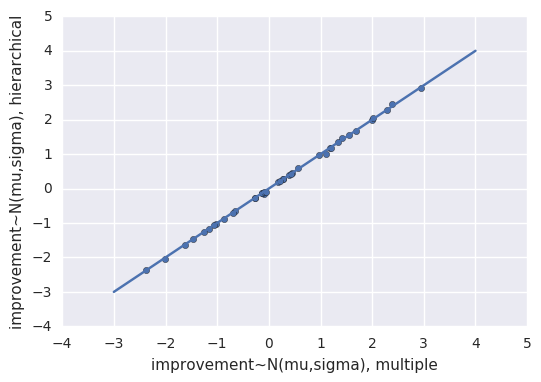

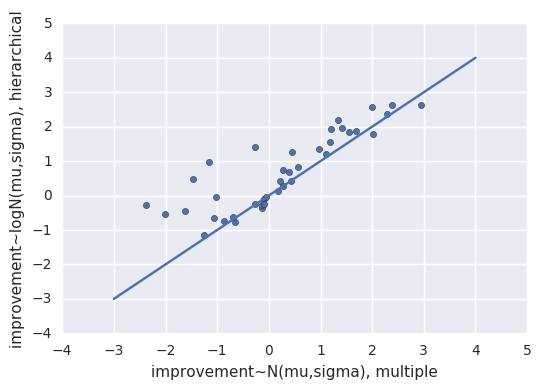

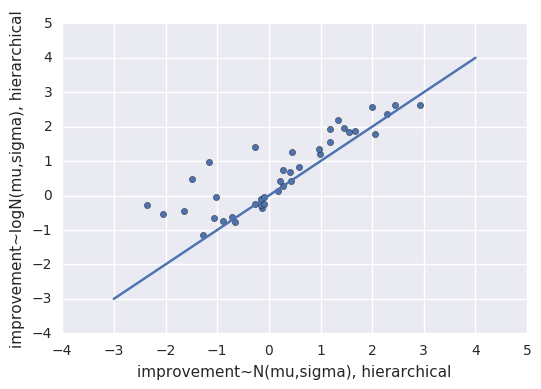

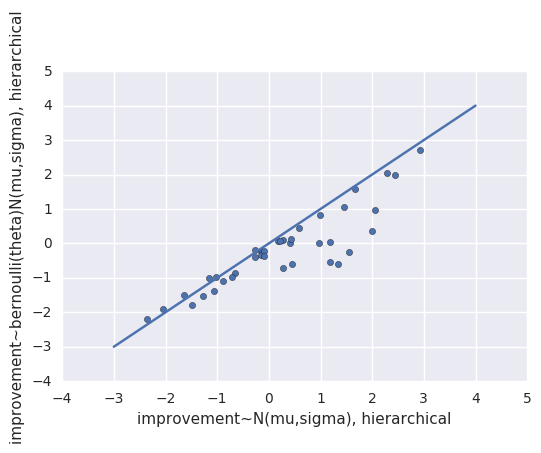

In [42]:
figure()
pd.DataFrame(technology_models_log_likelihood).plot('improvement~N(mu,sigma), multiple',
                                                   'improvement~N(mu,sigma), hierarchical', kind='scatter')
plot(xlim(), xlim())

pd.DataFrame(technology_models_log_likelihood).plot('improvement~N(mu,sigma), multiple',
                                                   'improvement~logN(mu,sigma), hierarchical', kind='scatter')
plot(xlim(), xlim())

figure()
pd.DataFrame(technology_models_log_likelihood).plot('improvement~N(mu,sigma), hierarchical',
                                                   'improvement~logN(mu,sigma), hierarchical', kind='scatter')
plot(xlim(), xlim())

figure()
pd.DataFrame(technology_models_log_likelihood).plot('improvement~N(mu,sigma), hierarchical',
                                                   'improvement~bernoulli(theta)N(mu,sigma), hierarchical', kind='scatter')
plot(xlim(), xlim())

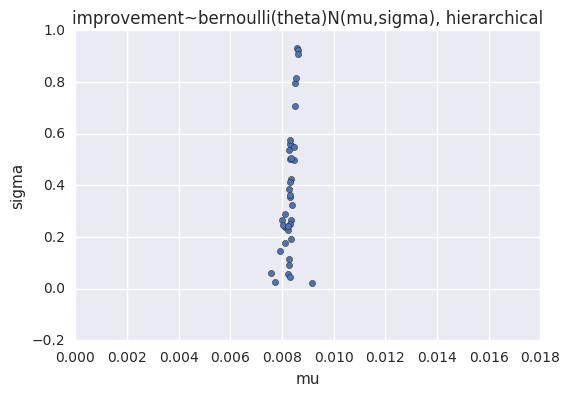

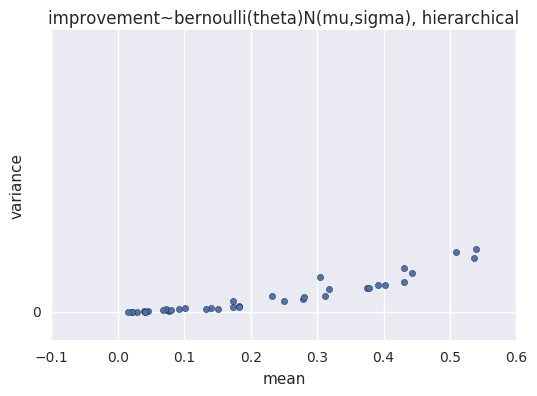

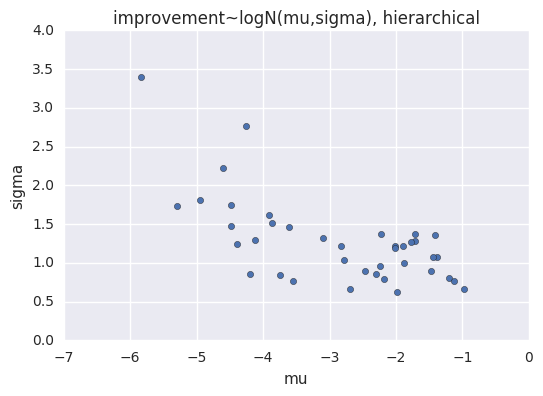

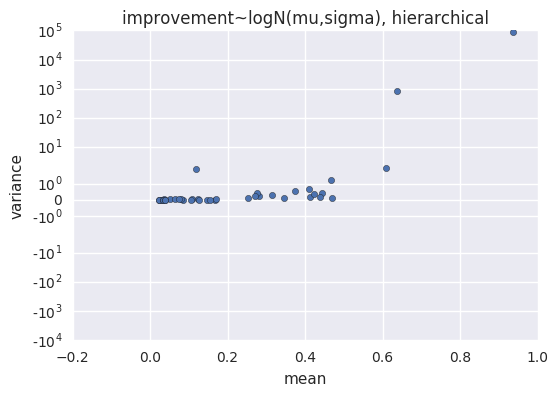

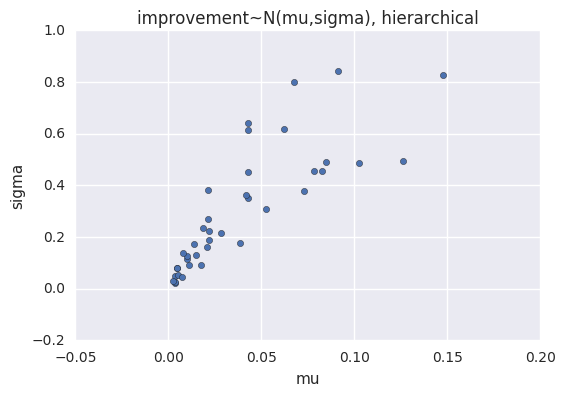

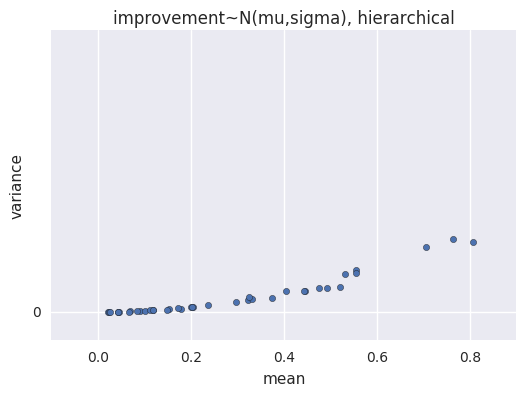

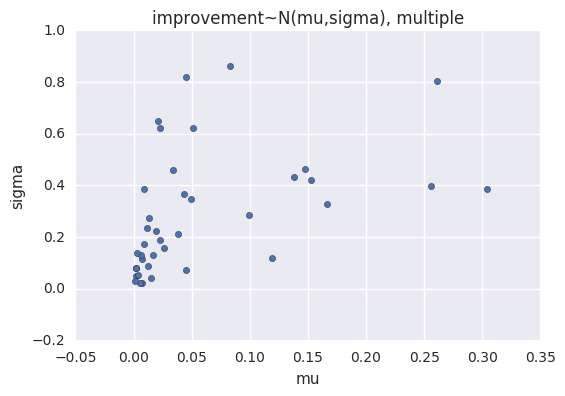

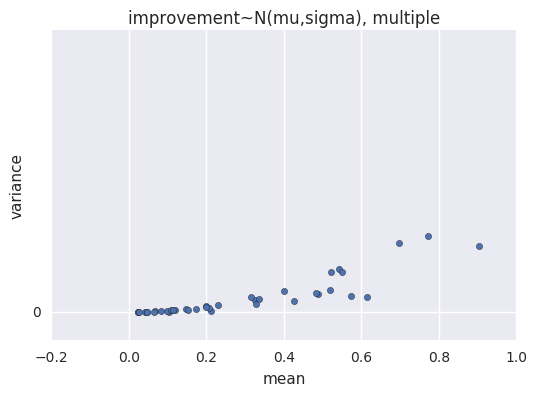

In [43]:
for model_type in technology_models_parameters.keys():
    technology_models_parameters[model_type].plot('mu', 'sigma',kind='scatter')
    title(model_type)
    technology_models_parameters[model_type].plot('mean', 'variance',kind='scatter')
    title(model_type)
    if ylim()[1]>10**3*ylim()[0]:
        yscale('symlog')

(1e-05, 100000.0)

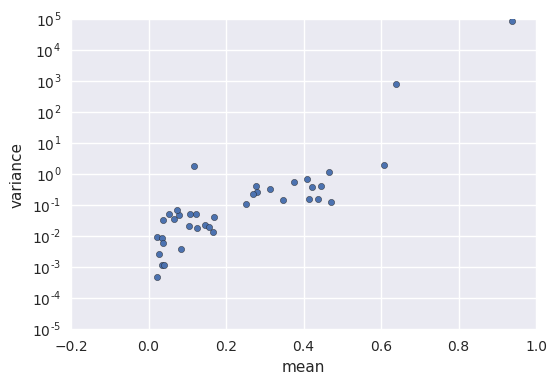

In [44]:
technology_models_parameters['improvement~logN(mu,sigma), hierarchical'].plot('mean', 'variance',kind='scatter')
yscale('log')
ylim(ymin=.00001)

Use Models to Predict the Future
===

In [45]:
training_years = arange(1950,2000,10)
horizons = [5,10,'all']


first_year = empirical_data.index[0]
time_series_from_each_time_period = {}

for training_year in training_years:
    print(training_year)

    start_ind = int(training_year-first_year)
    ### Select only those time series that have at least 3 data points from before the training year
    time_series_from_time_period = time_series.columns[time_series.iloc[:start_ind].notnull().sum(axis=0)>=3]
    time_series_from_each_time_period[training_year] = time_series_from_time_period
    
technology_forecast_models_Y_sim = {}
technology_forecast_models_log_pd = {}
technology_forecast_models_parameters = {}
technology_forecast_models_95CI = {}

1950
1960
1970
1980
1990


In [46]:
def predict_with_model(model_type, model_parameters, parameter_priors, 
                       time_series=time_series,
                       training_years=training_years, horizons=horizons,
                       time_series_from_each_time_period=time_series_from_each_time_period,
                       technology_forecast_models_log_pd=technology_forecast_models_log_pd,
                       technology_forecast_models_parameters=technology_forecast_models_parameters,
                       technology_forecast_models_95CI=technology_forecast_models_95CI,
                       target_tech_names=target_tech_names,
                       model_code=model_code,
                       print_output=True):
    
    technology_forecast_models_log_pd[model_type] = pd.Panel(items=target_tech_names,
         major_axis=horizons, 
         minor_axis=training_years)
    technology_forecast_models_95CI[model_type] = pd.Panel(items=target_tech_names,
         major_axis=horizons, 
         minor_axis=training_years)
    
    technology_forecast_models_parameters[model_type] = pd.Panel(items=target_tech_names,
             major_axis=model_parameters, 
             minor_axis=training_years)

    technology_forecast_models_Y_sim[model_type] = {}
    for training_year in training_years:
        print(training_year)

        forecast_start_ind = int(training_year-first_year)
        time_series_from_time_period = time_series_from_each_time_period[training_year]
        n_time_series_from_time_period = len(time_series_from_time_period)

        stan_data = {'N_technologies': n_time_series_from_time_period,
                     'N_time_periods': time_series.shape[0],
                'N_time_periods_for_inference': forecast_start_ind,
                 'Y': time_series[time_series_from_time_period].fillna(-999).T,
                         }
        stan_data = {**stan_data, **parameter_priors} 

        ###
        model_fit = stanity.fit(model_code[model_type], data=stan_data, n_jobs=n_jobs)
        Y_sim = model_fit['Y_sim']
        technology_forecast_models_Y_sim[model_type][training_year] = Y_sim
        
        if print_output:
            print(_print_stanfit(model_fit, model_parameters))
        for parameter in model_parameters:
            technology_forecast_models_parameters[model_type].ix[time_series_from_time_period, 
                                                        parameter,
                                                        training_year] = model_fit[parameter].mean(axis=0)

        for horizon in horizons:
            if horizon=='all':
                forecast_stop_ind = time_series.shape[0]
            else:
                forecast_stop_ind = horizon+forecast_start_ind
            
#             ll = nanmean(nanmean(model_fit['log_likelihood'][:,:,forecast_start_ind:forecast_stop_ind],axis=0),axis=1)
#             technology_forecast_models_log_likelihood[model_type].ix[time_series_from_time_period,
#                                                                  horizon,training_year] = ll
            times, techs = where(time_series[time_series_from_time_period].notnull())
            techs_to_forecast = techs[(forecast_start_ind<times)*(times<forecast_stop_ind)]
            times_to_forecast = times[(forecast_start_ind<times)*(times<forecast_stop_ind)]
            lpd = list(map(lambda x,y: x.logpdf(y)[0], 
                           map(gaussian_kde, Y_sim[:,techs_to_forecast,times_to_forecast].T), 
                           time_series[time_series_from_time_period].values[times_to_forecast, techs_to_forecast]))
            lpd = array(lpd)
            lpd[lpd==-inf] = log(finfo('d').tiny)
            lpd = pd.groupby(pd.Series(lpd),techs_to_forecast).sum()
            lpd = lpd.reindex(arange(len(time_series_from_time_period)))
            lpd.index = time_series_from_time_period
            technology_forecast_models_log_pd[model_type].ix[time_series_from_time_period,
                                                                 horizon,training_year] = lpd
#             CI95 = portion_of_forecast_within_CI(model_fit, 'Y_sim', 
#                                                  time_series[time_series_from_time_period].values, 
#                                                  forecast_start_ind, 
#                                                  forecast_stop_ind)
#             technology_forecast_models_95CI[model_type].ix[time_series_from_time_period,
#                                                            horizon,training_year] = CI95

In [ ]:
model_type = 'improvement~bernoulli(theta)N(mu,sigma), multiple'
model_parameters = ['mu', 'sigma', 'theta']
parameter_priors = {'mu_prior_location': 0,
                    'mu_prior_scale': 1,
                    'sigma_prior_location': 0,
                    'sigma_prior_scale': 2,
                    'theta_prior_location': .5,
                    'theta_prior_scale': 2
                }

predict_with_model(model_type, model_parameters, parameter_priors)

1950
Reusing model.
Ran in 192.164 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu[0]       0.48    0.01    0.5 5.4e-3   0.08    0.3   0.72   1.76   2176    1.0
mu[1]       0.71    0.05   0.11   0.57   0.64   0.69   0.74   0.96      4   1.45
mu[2]       0.67    0.02   0.41   0.03   0.34   0.67   0.94   1.58    288   1.01
mu[3]       0.06  1.5e-3   0.03 4.4e-3   0.04   0.07   0.09   0.11    415   1.02
mu[4]       0.07  1.4e-3   0.03 5.7e-3   0.05   0.07   0.09   0.11    442   1.01
mu[5]       1.61    0.05   0.64   0.13    1.2   1.95   2.05   2.29    168   1.03
mu[6]       0.06  1.0e-3   0.05 2.1e-3   0.02   0.04   0.08   0.17   2023    1.0
mu[7]       0.12  3.1e-3   0.09 3.5e-3   0.05    0.1   0.18   0.34    907   1.01
mu[8]       0.12  2.6e-3   0.09 4.9e-3   0.05    0.1   0.18   0.32   1217   1.01
mu[9]       0.08  1.3e-3   0.06 

In [ ]:
model_type = 'improvement~bernoulli(theta)N(mu,sigma), hierarchical'
model_parameters = ['mu', 'sigma', 'theta']
parameter_priors = {'mu_prior_location': 0,
                    'mu_prior_scale': 1,
                    'sigma_prior_location': 0,
                    'sigma_prior_scale': 2,
                    'theta_prior_location': .5,
                    'theta_prior_scale': 2
                }

predict_with_model(model_type, model_parameters, parameter_priors)

1950
Reusing model.


In [ ]:
model_type = 'improvement~N(mu,sigma), multiple'
model_parameters = ['mu', 'sigma']
parameter_priors = {'mu_prior_location': 0,
                    'mu_prior_scale': 3,
                    'sigma_prior_location': 0,
                    'sigma_prior_scale': 2,
                }
predict_with_model(model_type, model_parameters, parameter_priors)

In [47]:
model_type = 'improvement~N(mu,sigma), hierarchical'
model_parameters = ['mu', 'sigma']
parameter_priors = {'mu_prior_location': 0,
                    'mu_prior_scale': 3,
                    'sigma_prior_location': 0,
                    'sigma_prior_scale': 2,
                }

predict_with_model(model_type, model_parameters, parameter_priors)

1950
Reusing model.
Ran in 48.497 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu[0]     1.9e-3  3.7e-5 1.4e-3 2.6e-4 8.2e-4 1.5e-3 2.5e-3 5.5e-3   1425   1.01
mu[1]       0.02  3.0e-4   0.01 6.1e-3   0.02   0.02   0.03   0.05   1665    1.0
mu[2]       0.37    0.01   0.29   0.04   0.14   0.27   0.52   1.08    780   1.01
mu[3]     4.7e-3  6.7e-5 2.7e-3 9.1e-4 2.7e-3 4.2e-3 6.2e-3   0.01   1645    1.0
mu[4]     4.7e-3  6.5e-5 2.6e-3 9.5e-4 2.8e-3 4.3e-3 6.1e-3   0.01   1619    1.0
mu[5]       1.07    0.03    0.8   0.08   0.36    0.9   1.74   2.61    599   1.01
mu[6]       0.04  6.7e-4   0.03   0.01   0.03   0.04   0.06   0.11   1441    1.0
mu[7]       0.02  2.3e-4   0.01 4.4e-3   0.01   0.02   0.02   0.05   2107    1.0
mu[8]       0.02  1.9e-4 8.6e-3 3.7e-3   0.01   0.02   0.02   0.04   2025    1.0
mu[9]       0.02  2.8e-4   0.01 5

In [ ]:
model_type = 'improvement~logN(mu,sigma), multiple'
model_parameters = ['mu', 'sigma']
parameter_priors = {'mu_prior_location': 0,
                    'mu_prior_scale': 1,
                    'sigma_prior_location': 0,
                    'sigma_prior_scale': 2,
                }

predict_with_model(model_type, model_parameters, parameter_priors)

In [48]:
model_type = 'improvement~logN(mu,sigma), hierarchical'
model_parameters = ['mu', 'sigma']
parameter_priors = {'mu_prior_location': 0,
                    'mu_prior_scale': 1,
                    'sigma_prior_location': 0,
                    'sigma_prior_scale': 2,
                }

predict_with_model(model_type, model_parameters, parameter_priors)

1950
Reusing model.
Ran in 34.336 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu[0]      -5.56  6.4e-3    0.4  -6.38  -5.82  -5.55  -5.29  -4.78   4000    1.0
mu[1]      -5.57  7.9e-3    0.4  -6.41  -5.82  -5.55  -5.31  -4.82   2584    1.0
mu[2]       -0.5  7.8e-3   0.38   -1.4  -0.66  -0.45  -0.27   0.09   2417    1.0
mu[3]      -5.12  5.3e-3   0.33  -5.82  -5.33  -5.11  -4.89   -4.5   4000    1.0
mu[4]      -5.12  5.2e-3   0.33   -5.8  -5.32   -5.1  -4.89  -4.53   4000    1.0
mu[5]       0.58    0.03    0.4  -0.36   0.52   0.66   0.76   0.97    169   1.02
mu[6]      -1.92  2.0e-3   0.12  -2.18   -2.0  -1.92  -1.84  -1.69   4000    1.0
mu[7]      -3.66  5.1e-3   0.32  -4.35  -3.85  -3.64  -3.44  -3.08   4000    1.0
mu[8]      -6.16    0.01   0.58   -7.4  -6.52  -6.13  -5.76  -5.07   2522    1.0
mu[9]      -3.58  5.1e-3   0.32  

In [ ]:
model_type = 'improvement~bernoulli(theta)logN(mu,sigma), multiple'
model_parameters = ['mu', 'sigma', 'theta']
parameter_priors = {'mu_prior_location': 0,
                    'mu_prior_scale': 1,
                    'sigma_prior_location': 0,
                    'sigma_prior_scale': 2,
                    'theta_prior_location': .5,
                    'theta_prior_scale': 2
                }

predict_with_model(model_type, model_parameters, parameter_priors)

In [ ]:
model_type = 'improvement~bernoulli(theta)logN(mu,sigma), hierarchical'
model_parameters = ['mu', 'sigma', 'theta']
parameter_priors = {'mu_prior_location': 0,
                    'mu_prior_scale': 1,
                    'sigma_prior_location': 0,
                    'sigma_prior_scale': 2,
                    'theta_prior_location': .5,
                    'theta_prior_scale': 2
                }

predict_with_model(model_type, model_parameters, parameter_priors)

In [ ]:
# model_code['improvement~bernoulli(theta)N(mu,sigma), hierarchical'] ="""functions{
    
# int first_observation_ind(vector my_array){
#     int t;
#     t = 1;
#     while(my_array[t] < -900){
#       t = t+1;
#     }
#     return t;
# }

# int last_observation_ind(vector my_array, int length){
#     int last_observation;
#     last_observation = 0; 
#     for(t in 1:length){
#       if(my_array[t] > -900){
#           last_observation = t;
#       }
#     }
#     return last_observation;
# }


# int count_n_observations(vector my_array) {
#     int count;
#     count = 0;
#     for (t in 1:num_elements(my_array)) {
#         if(my_array[t] > -900){
#             count = count + 1;
#         }
#     }
#     return count;
# }

# real lower_truncated_normal_lpdf(real x, real mu, real sigma, real A) {
#     return(normal_lpdf(x | mu, sigma) - normal_lccdf(A | mu, sigma));
# }

# real lower_truncated_normal_lpdf_vector(vector x, real mu, real sigma, real A) {
#     return(normal_lpdf(x | mu, sigma) - normal_lccdf(A | mu, sigma));
# }

# }

# data {

# int N_technologies;
# int N_time_periods; // number of time periods
# vector[N_time_periods] Y[N_technologies]; // value each time period

# int N_time_periods_for_inference;

#             real mu_prior_location;
#             real mu_prior_scale;

#             real sigma_prior_location;
#             real sigma_prior_scale;
            
#             real theta_prior_location;
#             real theta_prior_scale;
            
# //vector<lower = 0, upper = 1>[N_technologies] theta;
# }

# transformed data {

# int first_observation[N_technologies];
# int last_observation[N_technologies];
# int N_observed_time_periods_for_inference[N_technologies];
# int r_observation_offset[N_technologies];
# int n_observations[N_technologies];
# int r_array_offset[N_technologies];

# for (tech in 1:N_technologies){
#   first_observation[tech] = first_observation_ind(Y[tech][1:N_time_periods_for_inference]);
#   last_observation[tech] = last_observation_ind(Y[tech][1:N_time_periods_for_inference], 
#                       N_time_periods_for_inference);

#   N_observed_time_periods_for_inference[tech] = last_observation[tech]-first_observation[tech] + 1;
#   r_observation_offset[tech] = first_observation[tech]-1;
#   n_observations[tech] = count_n_observations(Y[tech]);
# }
# r_array_offset[1] = 0;
# for (tech in 2:N_technologies){
#     r_array_offset[tech] = N_observed_time_periods_for_inference[tech-1]+r_array_offset[tech-1]-1;
# }

# }
  
# parameters {

#         vector<lower = 0,upper = 1>[sum(N_observed_time_periods_for_inference)-N_technologies] r_raw; // updates

#         vector<lower = 0>[N_technologies] mu;
#         vector<lower = 0>[N_technologies] sigma;
#         vector<lower = 0, upper = 1>[N_technologies] theta;

#         cholesky_factor_corr[3] L_Omega;
#         vector<lower = 0>[3] tau;

#         real<lower = 0> mu_mu;
#         real<lower = 0> mu_sigma;
#         real<lower = 0, upper = 1> mu_theta;
  

# }

# transformed parameters {

# // Identify where the first and last non-missing data points are in Y
# vector<lower = 0>[sum(N_observed_time_periods_for_inference)-
#                             N_technologies] r; // updates

# {
# // Dictate that the total change between each pair of observations is equal to the observed change between them
# // This is relevant for time periods with missing data
# int most_recent_observation;
# for (tech in 1:N_technologies){
#   most_recent_observation = first_observation[tech];
#   for(t in first_observation[tech]+1:last_observation[tech]) {
#       if(Y[tech][t] > -900) {
#         r[(r_array_offset[tech]+most_recent_observation-r_observation_offset[tech]):
#           (r_array_offset[tech]+(t-1)-r_observation_offset[tech])] = 
#         r_raw[(r_array_offset[tech]+most_recent_observation-r_observation_offset[tech]):
#           (r_array_offset[tech]+(t-1)-r_observation_offset[tech])] /
#         sum(r_raw[(r_array_offset[tech]+most_recent_observation-r_observation_offset[tech]):
#           (r_array_offset[tech]+(t-1)-r_observation_offset[tech])]) * 
#         (Y[tech][t]-Y[tech][most_recent_observation]);
#         most_recent_observation = t;
#         }
#     }
#   }
# }

# }

# model {
#             tau ~ cauchy(0, 2);
#             L_Omega ~ lkj_corr_cholesky(1);
#             mu_mu ~ normal(mu_prior_location, mu_prior_scale);
#             mu_sigma ~ cauchy(sigma_prior_location, sigma_prior_scale);
#             mu_theta ~ normal(theta_prior_location, theta_prior_scale);
            
#             {
#             matrix[N_technologies, 3] parvec;
#             vector[3] mu_parvec;

#             parvec = append_col(mu, append_col(sigma, theta));
#             mu_parvec[1] = mu_mu;
#             mu_parvec[2] = mu_sigma;
#             mu_parvec[3] = mu_theta;
            
#             for (tech in 1:N_technologies){
#                 parvec[tech] ~ multi_normal_cholesky(mu_parvec, diag_pre_multiply(tau, L_Omega));
#                 for(t in 1:N_observed_time_periods_for_inference[tech]-1){
#                     target += log_mix(theta[tech], 
#                               lower_truncated_normal_lpdf(r[r_array_offset[tech]+t] | mu[tech], sigma[tech], 0), 
#                               lower_truncated_normal_lpdf(r[r_array_offset[tech]+t] | 0, 0.01, 0));
#                 }
#             }
#             }
# }

# generated quantities {

# vector[N_time_periods] Y_sim[N_technologies];
# vector[N_time_periods_for_inference] log_likelihood[N_technologies];
# //real mean_change[N_technologies];
# //real variance_change[N_technologies];

# //for (tech in 1:N_technologies){
# //    mean_change = mean(r[r_array_offset[tech]:(r_array_offset[tech]+N_observed_time_periods_for_inference[tech])]);
# //    variance_change = variance(r[r_array_offset[tech]:(r_array_offset[tech]+N_observed_time_periods_for_inference[tech])]);
# //}

# //Fill out data in the missing periods
# for (tech in 1:N_technologies){
#     for(t in first_observation[tech]:last_observation[tech]) {
#       if(Y[tech][t] > -900){
#           Y_sim[tech][t] = Y[tech][t];
#       } else{
#           Y_sim[tech][t] = Y_sim[tech][t-1] + r[r_array_offset[tech]+(t-1)-r_observation_offset[tech]];
#       } 
#     }
# }
# {
# real increase_size;
# //Fill out future data points
# for (tech in 1:N_technologies){
#     for(t in last_observation[tech]+1:N_time_periods){
#         // Stan cannot yet generate numbers from a truncated distribution directly, so we have to do this silly thing. 
#         // As of version 2.12.0, the devs are still talking about it: https://github.com/stan-dev/math/issues/214
#         increase_size = -1.0;  
#         while (increase_size<0){
#             increase_size = bernoulli_rng(theta[tech]) * normal_rng(mu[tech],sigma[tech]);
#         }
#         Y_sim[tech][t] = increase_size + Y_sim[tech][t-1];
#     }
# }
# }

# //Fill out past data points
# {
# int t;
# real increase_size;
# for (tech in 1:N_technologies){
#     t = first_observation[tech];
#     while(t>1){
#         increase_size = -1.0;  
#         while (increase_size<0){
#             increase_size = bernoulli_rng(theta[tech]) * normal_rng(mu[tech],sigma[tech]);
#         }
#         Y_sim[tech][t-1] = Y_sim[tech][t] - increase_size;
#         t = t-1;
#     }
# }
# }

# for (tech in 1:N_technologies){
#     for(t in 2:N_time_periods_for_inference){
#         if(Y[tech][t] > -900){
                
#                     if((Y[tech][t]-Y_sim[tech][t-1])==0) {
#                         log_likelihood[tech][t] = log(1-theta[tech]);
#                     } else {
#                         log_likelihood[tech][t] = log(theta[tech]) + 
#                         lower_truncated_normal_lpdf(Y[tech][t]-Y_sim[tech][t-1]| mu[tech], sigma[tech], 0);
#                     }
                
#         }
#     }
# }
# }
# """

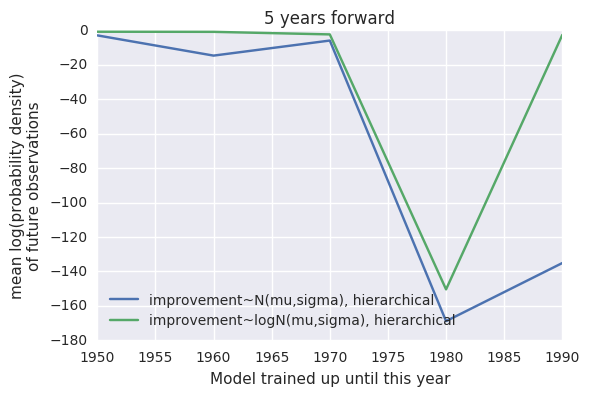

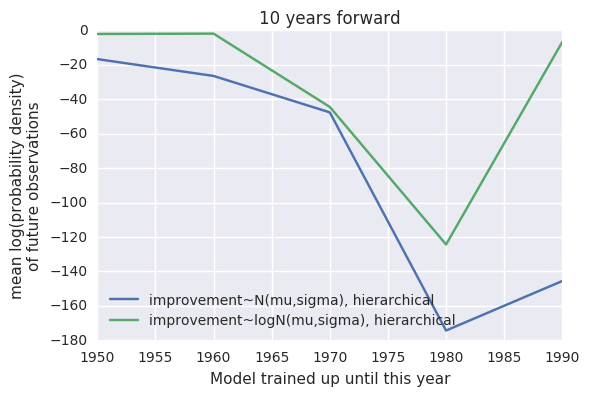

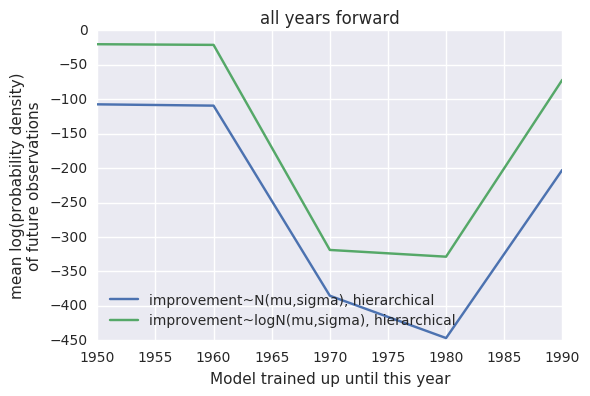

In [49]:
q = pd.Panel4D(technology_forecast_models_log_pd)
for i in arange(q.shape[2]):
    q.mean(axis=1).iloc[:,i].plot()
    title(str(q.major_axis[i])+' years forward')
    ylabel('mean log(probability density)\nof future observations')
    xlabel('Model trained up until this year')
#     yscale('symlog')
    legend(loc='lower left')

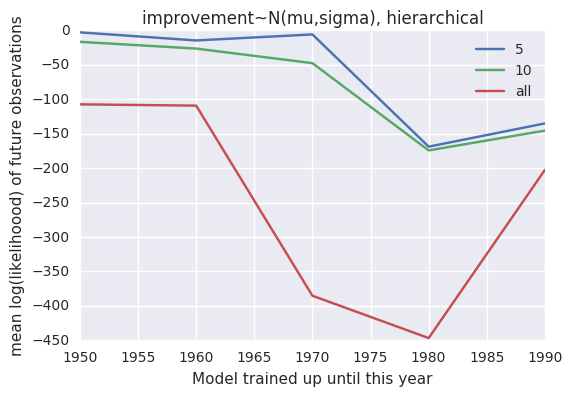

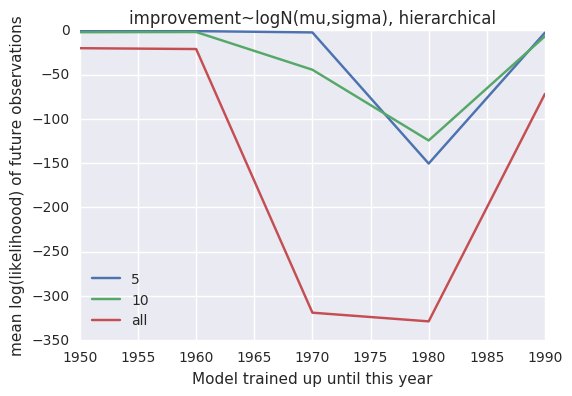

In [50]:
q = pd.Panel4D(technology_forecast_models_log_pd)
for i in q.labels:
    q[i].mean(axis=0).T.plot()
    title(i)
    ylabel('mean log(likelihoood) of future observations')
    xlabel('Model trained up until this year')

Previous Results
====

In [ ]:
q = pd.Panel4D(technology_models_prediction)
for i in arange(q.shape[2]):
    q.mean(axis=1).iloc[:,i].plot()
    title(str(q.major_axis[i])+' years forward')
    ylabel('mean log(likelihoood) of future observations')
    xlabel('Model trained up until this year')

In [ ]:
technology_models_prediction['improvement~N(mu,sigma), multiple'].mean(axis=0).T.plot()
yscale('symlog')

figure()

technology_models_prediction['improvement~N(mu,sigma), hierarchical'].mean(axis=0).T.plot()
yscale('symlog')

In [ ]:
technology_models_parameters['improvement~N(mu,sigma), multiple'].plot('mu', 'sigma', kind='scatter')
figure()
technology_models_parameters['improvement~N(mu,sigma), hierarchical'].plot('mu', 'sigma', kind='scatter')

The model with improvement~N(mu,sigma) (green line) typically predicts the future better than the model with improvement~bernoulli(theta)N(mu,sigma) (blue line). The simpler model does better prediction!

In [ ]:
for i in arange(len(time_series_from_time_period))[:10]:
    figure()
    title(time_series_from_time_period[i])
    plot_time_series_inference(model_fit,ind=i, x=data.index.values)
    scatter(time_series.index, time_series[time_series_from_time_period[i]])

In [ ]:
training_year = 1950
forecast_start_ind = int(training_year-first_year)
time_series_from_time_period = ['Milk (US)']#time_series_from_each_time_period[training_year]
n_time_series_from_time_period = len(time_series_from_time_period)

stan_data = {'N_technologies': n_time_series_from_time_period,
             'N_time_periods': time_series.shape[0],
        'N_time_periods_for_inference': forecast_start_ind,
         'Y': time_series[time_series_from_time_period].fillna(-999).T,
         }
model_parameters = ['mu', 'sigma', 'theta']
parameter_priors = {'mu_prior_location': .1,
                'mu_prior_scale': 1,
                'sigma_prior_location': 0,
                'sigma_prior_scale': 2,
                    'theta_prior_location': .5,
                    'theta_prior_scale': 2
#                     'theta': ones(len(time_series_from_time_period))*.5
            }
stan_data = {**stan_data, **parameter_priors} 

###
model_fit = stanity.fit(model_code['improvement~bernoulli(theta)N(mu,sigma), hierarchical'], data=stan_data, n_jobs=n_jobs)

Y_sim = model_fit['Y_sim']